## Generating Training and Test Data for the Mass-Spring-Damper Model 

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import cantera as ct
from scipy.integrate import solve_ivp

3.8.10 (default, May  4 2021, 03:05:50) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data_10SMD_Clean/'
TestDir    = WORKSPACE_PATH+'/ROMNet/Data_10SMD_Clean_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
try:
    os.makedirs(TestDir)
except OSError as e:
    pass

NTraining  = 10
NTest      = 10  
Nt         = 100
tout       = np.linspace(0.,15.,Nt)
SOLVER     = 'Radau'

In [3]:
### Defining ODE and its Parameters

def fOrig(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Source(t, y):
    return [y[1], -Params[2]/Params[0]*y[0]-Params[1]/Params[0]*y[1]]

def fOrig_Jacobian(t, y):

    Eps = 1e-6
    J   = np.zeros([len(y), len(y)], dtype = np.float)

    for i in range(len(y)):
        y1 = y.copy()
        y2 = y.copy()

        y1[i] += Eps
        y2[i] -= Eps

        f1 = np.array(fOrig(t, y1))
        f2 = np.array(fOrig(t, y2))

        J[ : , i] = (f1 - f2) / (2. * Eps)

    return J

Params = np.array([1.0, 0.5, 3.0], dtype=np.float64)

y0 =  [-1.65770643 -0.63922502]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.40491123  0.53441952]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.45905424 -0.64252607]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.87246968 -0.71148626]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.75643254 -0.72317876]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.15780636 -0.27154492]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.73225654 -0.24146003]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.5422017  -0.93394808]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.29523451 0.58610218]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.24291931 -0.91162943]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


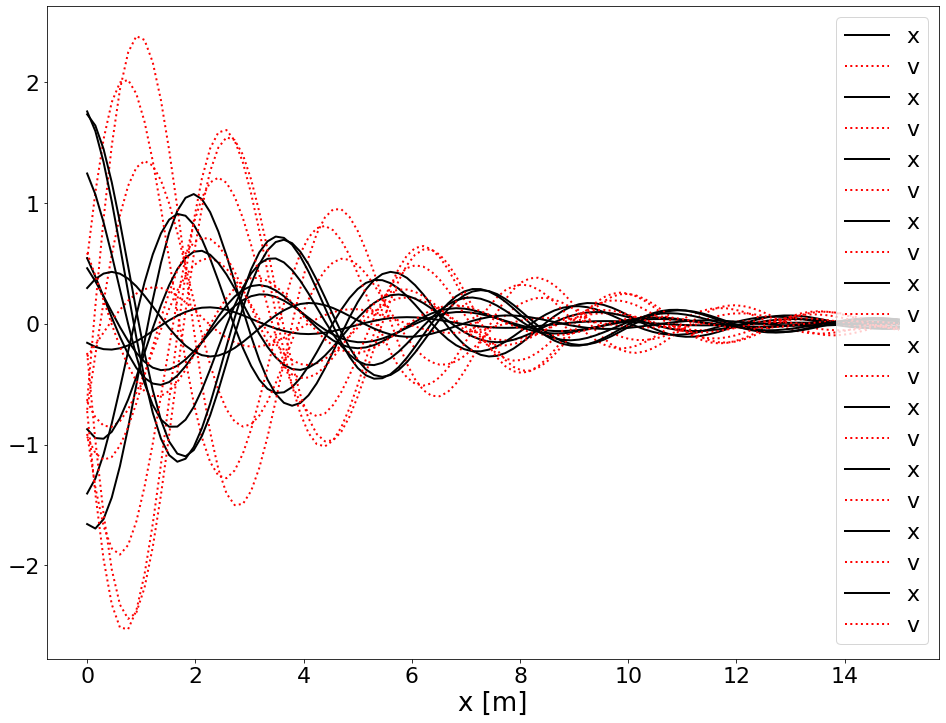

In [4]:
### Generating Training Data

# Sampling Initial Conditions
y0Mat      = np.zeros((NTraining,2))
y0Mat[:,0] = np.random.rand(NTraining)*4. - 2.0
y0Mat[:,1] = np.random.rand(NTraining)*2. - 1.0

fig   = plt.figure(figsize=(16, 12))
for iSample in range(NTraining):
    y0         = y0Mat[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    plt.plot(output.t, output.y[0,:], '-k', label='x')
    plt.plot(output.t, output.y[1,:], ':r', label='v')
    plt.legend()
    plt.xlabel('t [s]')
    plt.xlabel('x [m]')
        
    ySourceTemp = np.zeros_like(output.y)
    JJTauMat    = np.zeros((output.y.shape[1], output.y.shape[0]*2))
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])
        JJ                = fOrig_Jacobian(it, output.y[:,it])        
        JJEig, JJVec      = np.linalg.eig(JJ)
        JJTauMat[it,0:2]  = 1./JJEig.real
        JJTauMat[it,2:4]  = 1./JJEig.imag

    if (iSample == 0):
        tMat    = tMatTemp
        uMat    = uMatTemp
        yMat    = output.y.T 
        ySource = ySourceTemp.T
    else:
        tMat    = np.concatenate((tMat,    tMatTemp), axis=0)
        uMat    = np.concatenate((uMat,    uMatTemp), axis=0)
        yMat    = np.concatenate((yMat,    output.y.T), axis=0)
        ySource = np.concatenate((ySource, ySourceTemp.T), axis=0)
        

y0 =  [1.51019357 0.83665024]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.21555172 -0.47198484]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 1.03089013 -0.74414377]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [0.38800195 0.19423564]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [ 0.49547463 -0.43249737]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.40915037  0.02350017]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.81873509  0.6819423 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.88197643 -0.13433945]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-0.69370591  0.31640317]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


y0 =  [-1.57892478 -0.1054349 ]


/usr/local/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


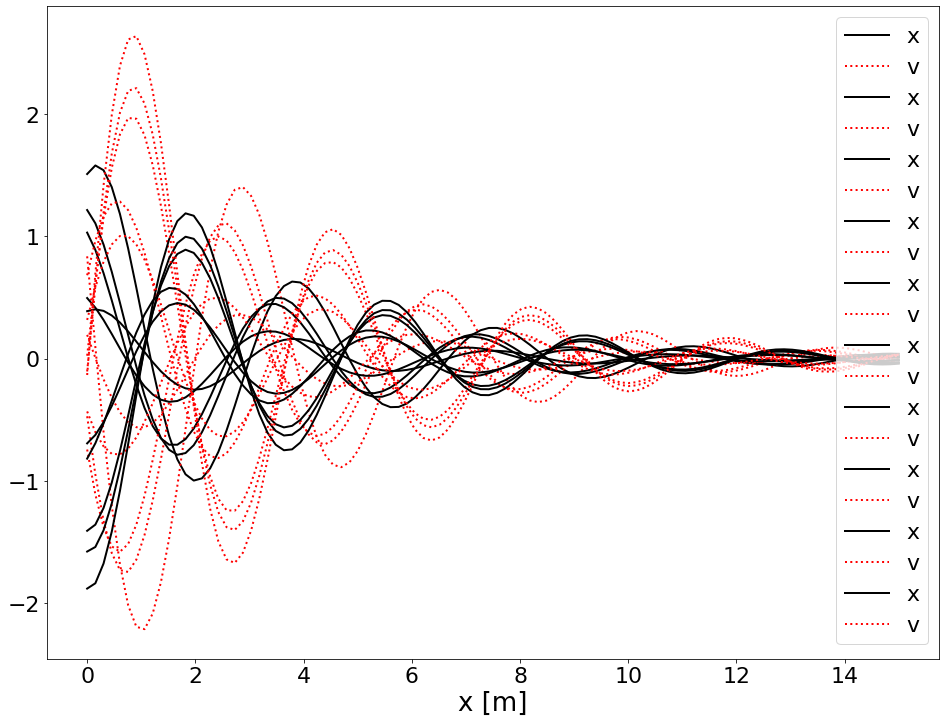

In [5]:
### Generating Test Data

# Sampling Initial Conditions
y0MatTest      = np.zeros((NTest,2))
y0MatTest[:,0] = np.random.rand(NTest)*4. - 2.0
y0MatTest[:,1] = np.random.rand(NTest)*2. - 1.0


fig   = plt.figure(figsize=(16, 12))
for iSample in range(NTest):
    y0         = y0MatTest[iSample,:]
    print('y0 = ', y0)
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0, method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    
    tMatTemp   = tout[...,np.newaxis]
    uMatTemp   = np.tile(y0, (Nt, 1))
    
    plt.plot(output.t, output.y[0,:], '-k', label='x')
    plt.plot(output.t, output.y[1,:], ':r', label='v')
    plt.legend()
    plt.xlabel('t [s]')
    plt.xlabel('x [m]')
        
    ySourceTemp = np.zeros_like(output.y)
    for it in range(Nt):
        ySourceTemp[:,it] = fOrig_Source(output.t, output.y[:,it])

    if (iSample == 0):
        tMatTest    = tMatTemp
        uMatTest    = uMatTemp
        yMatTest    = output.y.T 
        ySourceTest = ySourceTemp.T
    else:
        tMatTest    = np.concatenate((tMatTest,    tMatTemp), axis=0)
        uMatTest    = np.concatenate((uMatTest,    uMatTemp), axis=0)
        yMatTest    = np.concatenate((yMatTest,    output.y.T), axis=0)
        ySourceTest = np.concatenate((ySourceTest, ySourceTemp.T), axis=0)
        

In [6]:
### Saving Data

Header   = 't,x,v'
FileName = OutputDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMat,uMat), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 'x,v'
FileName = OutputDir+'/Output.csv'
np.savetxt(FileName, yMat, delimiter=',', header=Header, comments='')

Header   = 'dx,dv'
FileName = OutputDir+'/dOutput.csv'
np.savetxt(FileName, ySource, delimiter=',', header=Header, comments='')

Header   = 'real_1,real_2,imag_1,imag_2'
FileName = OutputDir + '/Jacobian.csv'
np.savetxt(FileName, JJTauMat,    delimiter=',', header=Header, comments='')

Header   = 't,x,v'
FileName = TestDir+'/Input.csv'
np.savetxt(FileName, np.concatenate((tMatTest,uMatTest), axis=1), delimiter=',', header=Header, comments='')
        
Header   = 'x,v'
FileName = TestDir+'/Output.csv'
np.savetxt(FileName, yMatTest, delimiter=',', header=Header, comments='')

Header   = 'dx,dv'
FileName = TestDir+'/dOutput.csv'
np.savetxt(FileName, ySourceTest, delimiter=',', header=Header, comments='')

## Testing Surrogated-Sources Approach

In [7]:
### Importing Libraries

import tensorflow  as tf
from tensorflow.keras              import backend as K
from tensorflow.keras              import activations, initializers
from tensorflow.keras.models       import Sequential
from tensorflow.keras.layers       import Layer, Dense, Activation, Dropout
from tensorflow.keras              import Input
from tensorflow.keras.regularizers import l2

from sklearn.model_selection       import train_test_split
from sklearn.preprocessing         import StandardScaler

In [8]:
### Input Data

NNeurons           = [16,32,64,32,16]
Activations        = [activations.tanh, activations.tanh, activations.tanh, activations.tanh, activations.tanh]
NEpoch             = 10000
NBatch             = 64
LearningRate       = 5.e-4
OptimizerName      = tf.optimizers.Adam

Text(0.5, 0, 'dv/dt')

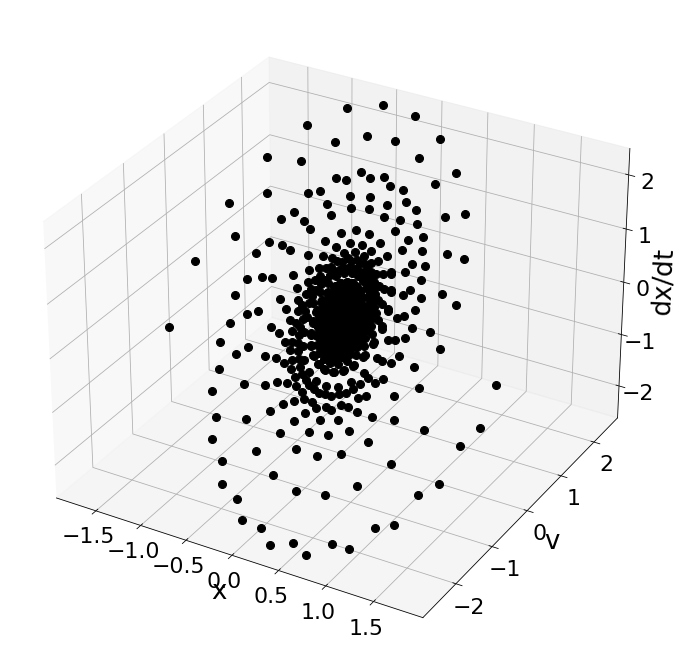

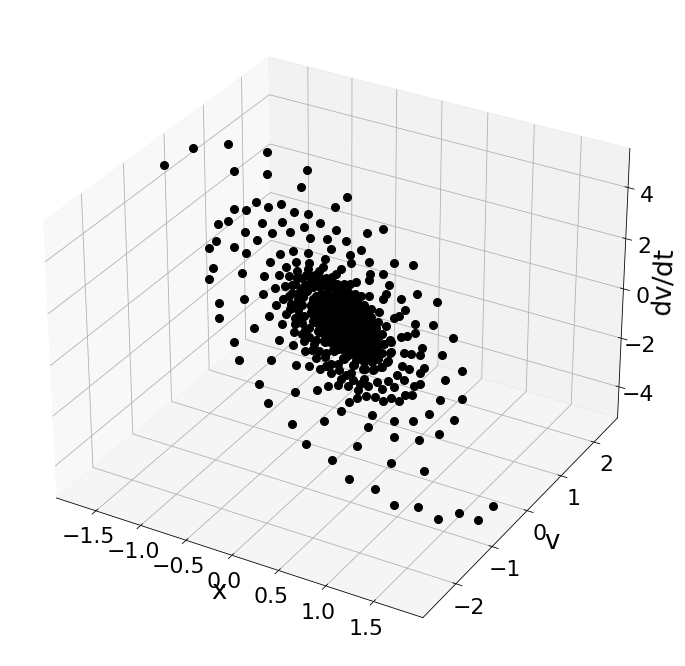

In [9]:
# Plotting Sources vs States

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat[:,0], yMat[:,1], ySource[:,0], 'ok',  linewidth=2)
ax.set_xlabel(r'x')
ax.set_ylabel(r'v')
ax.set_zlabel(r'dx/dt')

fig  = plt.figure(figsize=(16,12))
ax   = plt.axes(projection='3d')
ax.plot3D(yMat[:,0], yMat[:,1], ySource[:,1], 'ok',  linewidth=2)
ax.set_xlabel(r'x')
ax.set_ylabel(r'v')
ax.set_zlabel(r'dv/dt')

In [10]:
### Normalizing Data

Nx = yMat.shape[1]
Nd = yMat.shape[0]
Ny = ySource.shape[1]

xMax     = yMat.max(0)
xMin     = yMat.min(0)
xRange   = (xMax-xMin)
yMatt    = (yMat-xMin)/xRange

yMax     = ySource.max(0)
yMin     = ySource.min(0)
yRange   = (yMax-yMin)
ySourcee = (ySource-yMin)/yRange

In [11]:
### Splitting Data

XTrain, XTest, yTrain, yTest = train_test_split(yMatt, ySourcee, test_size=0.2, random_state=3)

In [12]:
### Creating Surrogate

LengthScale               = 5.e-2
Tau                       = 1.
RegCoeff                  = LengthScale**2 * (1.) / (2. * Nd * Tau)

NNModel = tf.keras.models.Sequential()

NNModel.add(Dense(NNeurons[0], input_shape=(Nx,), activation=Activations[0], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
for iHL in range(1, len(NNeurons)):
    NNModel.add(Dense(NNeurons[iHL], activation=Activations[iHL], kernel_regularizer=l2(RegCoeff), bias_regularizer=l2(RegCoeff) ))
NNModel.add(Dense(Ny, activation='linear'))
NNModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 5,346
Trainable params: 5,346
Non-trainable params: 0
______________________________________________________

Epoch 1/10000
13/13 [==============================] - 1s 16ms/step - loss: 0.1299 - val_loss: 0.0196
Epoch 2/10000
13/13 [==============================] - 0s 3ms/step - loss: 0.0147 - val_loss: 0.0174
Epoch 3/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0083
Epoch 4/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 5/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 6/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 7/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0051
Epoch 8/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0047
Epoch 9/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 10/10000
13/13 [==============================] - 0s 2ms/step - loss: 0.0046 - val_l

13/13 [==============================] - 0s 2ms/step - loss: 2.1473e-04 - val_loss: 2.2385e-04
Epoch 78/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1278e-04 - val_loss: 2.2121e-04
Epoch 79/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1232e-04 - val_loss: 2.2250e-04
Epoch 80/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1189e-04 - val_loss: 2.2555e-04
Epoch 81/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1318e-04 - val_loss: 2.2631e-04
Epoch 82/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1373e-04 - val_loss: 2.2091e-04
Epoch 83/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1277e-04 - val_loss: 2.2690e-04
Epoch 84/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1165e-04 - val_loss: 2.2299e-04
Epoch 85/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1161e-04 - val_loss: 2.1839e-04
Epoch 86/10000
13/13 [===

13/13 [==============================] - 0s 2ms/step - loss: 1.9020e-04 - val_loss: 1.9596e-04
Epoch 152/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9139e-04 - val_loss: 1.9818e-04
Epoch 153/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9086e-04 - val_loss: 1.9926e-04
Epoch 154/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9189e-04 - val_loss: 1.9761e-04
Epoch 155/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9065e-04 - val_loss: 1.9830e-04
Epoch 156/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9203e-04 - val_loss: 1.9633e-04
Epoch 157/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8947e-04 - val_loss: 1.9500e-04
Epoch 158/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8968e-04 - val_loss: 1.9470e-04
Epoch 159/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8956e-04 - val_loss: 1.9601e-04
Epoch 160/10000
1

Epoch 225/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8295e-04 - val_loss: 1.9386e-04
Epoch 226/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8847e-04 - val_loss: 1.8948e-04
Epoch 227/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8012e-04 - val_loss: 1.8403e-04
Epoch 228/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7972e-04 - val_loss: 1.8957e-04
Epoch 229/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8073e-04 - val_loss: 1.8406e-04
Epoch 230/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7910e-04 - val_loss: 1.8467e-04
Epoch 231/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7865e-04 - val_loss: 1.8218e-04
Epoch 232/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8022e-04 - val_loss: 1.9157e-04
Epoch 233/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8310e-04 - val_loss: 1.8317e-04
E

Epoch 299/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7397e-04 - val_loss: 1.8274e-04
Epoch 300/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7838e-04 - val_loss: 1.7450e-04
Epoch 301/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7189e-04 - val_loss: 1.7449e-04
Epoch 302/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7246e-04 - val_loss: 1.7827e-04
Epoch 303/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7576e-04 - val_loss: 1.7386e-04
Epoch 304/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7314e-04 - val_loss: 1.7567e-04
Epoch 305/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8322e-04 - val_loss: 1.7639e-04
Epoch 306/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8025e-04 - val_loss: 1.7744e-04
Epoch 307/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7379e-04 - val_loss: 1.7668e-04
E

Epoch 373/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6605e-04 - val_loss: 1.6902e-04
Epoch 374/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6351e-04 - val_loss: 1.6574e-04
Epoch 375/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6287e-04 - val_loss: 1.6716e-04
Epoch 376/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6452e-04 - val_loss: 1.7176e-04
Epoch 377/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6739e-04 - val_loss: 1.6512e-04
Epoch 378/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6345e-04 - val_loss: 1.6746e-04
Epoch 379/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6441e-04 - val_loss: 1.6779e-04
Epoch 380/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6457e-04 - val_loss: 1.6914e-04
Epoch 381/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6744e-04 - val_loss: 1.6474e-04
E

Epoch 447/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6110e-04 - val_loss: 1.6160e-04
Epoch 448/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5863e-04 - val_loss: 1.6713e-04
Epoch 449/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5960e-04 - val_loss: 1.7116e-04
Epoch 450/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5859e-04 - val_loss: 1.5655e-04
Epoch 451/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5873e-04 - val_loss: 1.5795e-04
Epoch 452/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5907e-04 - val_loss: 1.6038e-04
Epoch 453/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5590e-04 - val_loss: 1.5841e-04
Epoch 454/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5814e-04 - val_loss: 1.5969e-04
Epoch 455/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6004e-04 - val_loss: 1.6124e-04
E

Epoch 521/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4972e-04 - val_loss: 1.4974e-04
Epoch 522/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4972e-04 - val_loss: 1.5146e-04
Epoch 523/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4913e-04 - val_loss: 1.5260e-04
Epoch 524/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4952e-04 - val_loss: 1.5072e-04
Epoch 525/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4884e-04 - val_loss: 1.5469e-04
Epoch 526/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4960e-04 - val_loss: 1.5116e-04
Epoch 527/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6071e-04 - val_loss: 1.5219e-04
Epoch 528/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5755e-04 - val_loss: 1.5146e-04
Epoch 529/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5440e-04 - val_loss: 1.4887e-04
E

Epoch 595/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4140e-04 - val_loss: 1.4227e-04
Epoch 596/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4516e-04 - val_loss: 1.4310e-04
Epoch 597/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5131e-04 - val_loss: 1.4327e-04
Epoch 598/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4615e-04 - val_loss: 1.4261e-04
Epoch 599/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4153e-04 - val_loss: 1.4283e-04
Epoch 600/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4230e-04 - val_loss: 1.4385e-04
Epoch 601/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4278e-04 - val_loss: 1.4667e-04
Epoch 602/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5156e-04 - val_loss: 1.5814e-04
Epoch 603/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5930e-04 - val_loss: 1.7883e-04
E

Epoch 669/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3744e-04 - val_loss: 1.4480e-04
Epoch 670/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3827e-04 - val_loss: 1.3826e-04
Epoch 671/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3528e-04 - val_loss: 1.3685e-04
Epoch 672/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3477e-04 - val_loss: 1.3759e-04
Epoch 673/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3567e-04 - val_loss: 1.4728e-04
Epoch 674/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4311e-04 - val_loss: 1.4873e-04
Epoch 675/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3928e-04 - val_loss: 1.3986e-04
Epoch 676/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3686e-04 - val_loss: 1.3902e-04
Epoch 677/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4045e-04 - val_loss: 1.3670e-04
E

Epoch 743/10000
13/13 [==============================] - 0s 5ms/step - loss: 1.3390e-04 - val_loss: 1.3284e-04
Epoch 744/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.3235e-04 - val_loss: 1.2935e-04
Epoch 745/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3000e-04 - val_loss: 1.3265e-04
Epoch 746/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3007e-04 - val_loss: 1.2929e-04
Epoch 747/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2976e-04 - val_loss: 1.2893e-04
Epoch 748/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2880e-04 - val_loss: 1.3105e-04
Epoch 749/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2926e-04 - val_loss: 1.2767e-04
Epoch 750/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2719e-04 - val_loss: 1.2656e-04
Epoch 751/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2753e-04 - val_loss: 1.2819e-04
E

Epoch 817/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2281e-04 - val_loss: 1.2642e-04
Epoch 818/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2287e-04 - val_loss: 1.2241e-04
Epoch 819/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2202e-04 - val_loss: 1.2344e-04
Epoch 820/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2148e-04 - val_loss: 1.2228e-04
Epoch 821/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2089e-04 - val_loss: 1.2070e-04
Epoch 822/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2217e-04 - val_loss: 1.2187e-04
Epoch 823/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1974e-04 - val_loss: 1.2089e-04
Epoch 824/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2132e-04 - val_loss: 1.2976e-04
Epoch 825/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2235e-04 - val_loss: 1.2234e-04
E

Epoch 891/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1366e-04 - val_loss: 1.1554e-04
Epoch 892/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1566e-04 - val_loss: 1.1523e-04
Epoch 893/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1379e-04 - val_loss: 1.1387e-04
Epoch 894/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1420e-04 - val_loss: 1.1721e-04
Epoch 895/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1573e-04 - val_loss: 1.1931e-04
Epoch 896/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1569e-04 - val_loss: 1.1370e-04
Epoch 897/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1399e-04 - val_loss: 1.1454e-04
Epoch 898/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1434e-04 - val_loss: 1.1325e-04
Epoch 899/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1521e-04 - val_loss: 1.1485e-04
E

Epoch 965/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1137e-04 - val_loss: 1.0922e-04
Epoch 966/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1392e-04 - val_loss: 1.1009e-04
Epoch 967/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0746e-04 - val_loss: 1.0891e-04
Epoch 968/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0748e-04 - val_loss: 1.0758e-04
Epoch 969/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0737e-04 - val_loss: 1.1195e-04
Epoch 970/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0999e-04 - val_loss: 1.0803e-04
Epoch 971/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0832e-04 - val_loss: 1.1040e-04
Epoch 972/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0793e-04 - val_loss: 1.0724e-04
Epoch 973/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0678e-04 - val_loss: 1.0695e-04
E

13/13 [==============================] - 0s 2ms/step - loss: 1.0432e-04 - val_loss: 1.0181e-04
Epoch 1039/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0299e-04 - val_loss: 1.0724e-04
Epoch 1040/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0753e-04 - val_loss: 1.0951e-04
Epoch 1041/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0330e-04 - val_loss: 1.0213e-04
Epoch 1042/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0181e-04 - val_loss: 1.0400e-04
Epoch 1043/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0502e-04 - val_loss: 1.0790e-04
Epoch 1044/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0736e-04 - val_loss: 1.2578e-04
Epoch 1045/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0937e-04 - val_loss: 1.0542e-04
Epoch 1046/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0347e-04 - val_loss: 1.0779e-04
Epoch 104

13/13 [==============================] - 0s 2ms/step - loss: 1.0324e-04 - val_loss: 1.0466e-04
Epoch 1112/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0037e-04 - val_loss: 1.0294e-04
Epoch 1113/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.9298e-05 - val_loss: 9.7574e-05
Epoch 1114/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.6941e-05 - val_loss: 9.6615e-05
Epoch 1115/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.5805e-05 - val_loss: 9.7474e-05
Epoch 1116/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.6137e-05 - val_loss: 9.8294e-05
Epoch 1117/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.6712e-05 - val_loss: 9.8443e-05
Epoch 1118/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.5881e-05 - val_loss: 9.6845e-05
Epoch 1119/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.5488e-05 - val_loss: 9.6728e-05
Epoch 112

13/13 [==============================] - 0s 2ms/step - loss: 9.2297e-05 - val_loss: 9.3329e-05
Epoch 1185/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.2269e-05 - val_loss: 9.2821e-05
Epoch 1186/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.0943e-05 - val_loss: 9.2945e-05
Epoch 1187/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.2458e-05 - val_loss: 9.4091e-05
Epoch 1188/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0022e-04 - val_loss: 1.0251e-04
Epoch 1189/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.6943e-05 - val_loss: 9.5137e-05
Epoch 1190/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.2840e-05 - val_loss: 9.6366e-05
Epoch 1191/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.2977e-05 - val_loss: 9.1895e-05
Epoch 1192/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.1647e-05 - val_loss: 9.4757e-05
Epoch 119

13/13 [==============================] - 0s 2ms/step - loss: 8.7217e-05 - val_loss: 8.8845e-05
Epoch 1258/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.8889e-05 - val_loss: 8.7983e-05
Epoch 1259/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.7423e-05 - val_loss: 8.8351e-05
Epoch 1260/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.7661e-05 - val_loss: 8.7138e-05
Epoch 1261/10000
13/13 [==============================] - 0s 3ms/step - loss: 9.0693e-05 - val_loss: 9.0144e-05
Epoch 1262/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.8007e-05 - val_loss: 8.7297e-05
Epoch 1263/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.7442e-05 - val_loss: 8.8448e-05
Epoch 1264/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.8078e-05 - val_loss: 8.6433e-05
Epoch 1265/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.7461e-05 - val_loss: 9.5402e-05
Epoch 126

13/13 [==============================] - 0s 2ms/step - loss: 8.2946e-05 - val_loss: 8.2835e-05
Epoch 1331/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.1821e-05 - val_loss: 8.2779e-05
Epoch 1332/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.1633e-05 - val_loss: 8.3383e-05
Epoch 1333/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.3313e-05 - val_loss: 8.2327e-05
Epoch 1334/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.8065e-05 - val_loss: 1.0381e-04
Epoch 1335/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.5260e-05 - val_loss: 8.2309e-05
Epoch 1336/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.1992e-05 - val_loss: 8.2437e-05
Epoch 1337/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.2333e-05 - val_loss: 8.5072e-05
Epoch 1338/10000
13/13 [==============================] - 0s 3ms/step - loss: 8.2867e-05 - val_loss: 9.0076e-05
Epoch 133

13/13 [==============================] - 0s 2ms/step - loss: 7.8404e-05 - val_loss: 8.0296e-05
Epoch 1404/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.8690e-05 - val_loss: 7.8102e-05
Epoch 1405/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.9569e-05 - val_loss: 8.1921e-05
Epoch 1406/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.1914e-05 - val_loss: 8.6611e-05
Epoch 1407/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.0754e-05 - val_loss: 8.6659e-05
Epoch 1408/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.0856e-05 - val_loss: 7.8710e-05
Epoch 1409/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.9995e-05 - val_loss: 7.7955e-05
Epoch 1410/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.0817e-05 - val_loss: 8.2784e-05
Epoch 1411/10000
13/13 [==============================] - 0s 2ms/step - loss: 8.1270e-05 - val_loss: 8.4684e-05
Epoch 141

13/13 [==============================] - 0s 2ms/step - loss: 7.3694e-05 - val_loss: 7.5257e-05
Epoch 1477/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.3964e-05 - val_loss: 7.3840e-05
Epoch 1478/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.3599e-05 - val_loss: 7.4999e-05
Epoch 1479/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.4233e-05 - val_loss: 7.8919e-05
Epoch 1480/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.4810e-05 - val_loss: 7.7175e-05
Epoch 1481/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.4432e-05 - val_loss: 7.4189e-05
Epoch 1482/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.4611e-05 - val_loss: 7.3640e-05
Epoch 1483/10000
13/13 [==============================] - 0s 3ms/step - loss: 7.3154e-05 - val_loss: 7.3579e-05
Epoch 1484/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.5247e-05 - val_loss: 7.3814e-05
Epoch 148

13/13 [==============================] - 0s 3ms/step - loss: 7.0433e-05 - val_loss: 7.0720e-05
Epoch 1550/10000
13/13 [==============================] - 0s 3ms/step - loss: 7.0971e-05 - val_loss: 7.0522e-05
Epoch 1551/10000
13/13 [==============================] - 0s 3ms/step - loss: 7.0089e-05 - val_loss: 7.1171e-05
Epoch 1552/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.9993e-05 - val_loss: 7.4133e-05
Epoch 1553/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.1857e-05 - val_loss: 7.0368e-05
Epoch 1554/10000
13/13 [==============================] - 0s 3ms/step - loss: 7.0279e-05 - val_loss: 7.0955e-05
Epoch 1555/10000
13/13 [==============================] - 0s 3ms/step - loss: 7.0186e-05 - val_loss: 7.0152e-05
Epoch 1556/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.0917e-05 - val_loss: 6.9383e-05
Epoch 1557/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.0462e-05 - val_loss: 7.0169e-05
Epoch 155

13/13 [==============================] - 0s 2ms/step - loss: 6.7535e-05 - val_loss: 6.6647e-05
Epoch 1623/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.6669e-05 - val_loss: 6.6153e-05
Epoch 1624/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.5753e-05 - val_loss: 6.6247e-05
Epoch 1625/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.6803e-05 - val_loss: 6.7012e-05
Epoch 1626/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.7874e-05 - val_loss: 6.6567e-05
Epoch 1627/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.8137e-05 - val_loss: 6.7840e-05
Epoch 1628/10000
13/13 [==============================] - 0s 2ms/step - loss: 7.1195e-05 - val_loss: 6.7630e-05
Epoch 1629/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.9220e-05 - val_loss: 6.7998e-05
Epoch 1630/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.6589e-05 - val_loss: 6.6718e-05
Epoch 163

13/13 [==============================] - 0s 2ms/step - loss: 6.3188e-05 - val_loss: 6.3287e-05
Epoch 1696/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.3172e-05 - val_loss: 6.3220e-05
Epoch 1697/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.2523e-05 - val_loss: 6.3066e-05
Epoch 1698/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.2692e-05 - val_loss: 6.2494e-05
Epoch 1699/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.3373e-05 - val_loss: 6.6053e-05
Epoch 1700/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.4569e-05 - val_loss: 6.3074e-05
Epoch 1701/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.3442e-05 - val_loss: 6.2904e-05
Epoch 1702/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.3044e-05 - val_loss: 6.2598e-05
Epoch 1703/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.3997e-05 - val_loss: 6.3121e-05
Epoch 170

13/13 [==============================] - 0s 2ms/step - loss: 6.1799e-05 - val_loss: 6.0614e-05
Epoch 1769/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.1454e-05 - val_loss: 6.0065e-05
Epoch 1770/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.0133e-05 - val_loss: 6.0898e-05
Epoch 1771/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.0228e-05 - val_loss: 6.1223e-05
Epoch 1772/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.1072e-05 - val_loss: 6.2271e-05
Epoch 1773/10000
13/13 [==============================] - 0s 3ms/step - loss: 6.1646e-05 - val_loss: 6.3440e-05
Epoch 1774/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.2219e-05 - val_loss: 5.9630e-05
Epoch 1775/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.0978e-05 - val_loss: 6.2207e-05
Epoch 1776/10000
13/13 [==============================] - 0s 2ms/step - loss: 6.1838e-05 - val_loss: 5.9413e-05
Epoch 177

13/13 [==============================] - 0s 2ms/step - loss: 5.7473e-05 - val_loss: 5.7454e-05
Epoch 1842/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.7639e-05 - val_loss: 6.1672e-05
Epoch 1843/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.7122e-05 - val_loss: 5.7500e-05
Epoch 1844/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.7515e-05 - val_loss: 5.8536e-05
Epoch 1845/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.7423e-05 - val_loss: 5.9049e-05
Epoch 1846/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.7164e-05 - val_loss: 5.8868e-05
Epoch 1847/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.8385e-05 - val_loss: 5.6871e-05
Epoch 1848/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.7827e-05 - val_loss: 5.7180e-05
Epoch 1849/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.6333e-05 - val_loss: 5.7015e-05
Epoch 185

13/13 [==============================] - 0s 3ms/step - loss: 5.4616e-05 - val_loss: 5.5252e-05
Epoch 1915/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.4575e-05 - val_loss: 5.5498e-05
Epoch 1916/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.4639e-05 - val_loss: 5.5623e-05
Epoch 1917/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.4813e-05 - val_loss: 5.6086e-05
Epoch 1918/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.5495e-05 - val_loss: 5.4379e-05
Epoch 1919/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.4368e-05 - val_loss: 5.4815e-05
Epoch 1920/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.4317e-05 - val_loss: 5.4614e-05
Epoch 1921/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.3965e-05 - val_loss: 5.4274e-05
Epoch 1922/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.5573e-05 - val_loss: 5.4244e-05
Epoch 192

13/13 [==============================] - 0s 2ms/step - loss: 5.1693e-05 - val_loss: 5.2219e-05
Epoch 1988/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1613e-05 - val_loss: 5.1817e-05
Epoch 1989/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1336e-05 - val_loss: 5.2000e-05
Epoch 1990/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1451e-05 - val_loss: 5.2089e-05
Epoch 1991/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.1454e-05 - val_loss: 5.2983e-05
Epoch 1992/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1991e-05 - val_loss: 5.2144e-05
Epoch 1993/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1905e-05 - val_loss: 5.2175e-05
Epoch 1994/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.2342e-05 - val_loss: 5.1638e-05
Epoch 1995/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1775e-05 - val_loss: 5.1316e-05
Epoch 199

13/13 [==============================] - 0s 3ms/step - loss: 4.9000e-05 - val_loss: 4.9708e-05
Epoch 2061/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.9953e-05 - val_loss: 5.0916e-05
Epoch 2062/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.0178e-05 - val_loss: 4.9719e-05
Epoch 2063/10000
13/13 [==============================] - 0s 3ms/step - loss: 5.1517e-05 - val_loss: 5.1566e-05
Epoch 2064/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.1299e-05 - val_loss: 5.0451e-05
Epoch 2065/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.0537e-05 - val_loss: 5.1112e-05
Epoch 2066/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.9276e-05 - val_loss: 5.0327e-05
Epoch 2067/10000
13/13 [==============================] - 0s 2ms/step - loss: 5.0546e-05 - val_loss: 4.9079e-05
Epoch 2068/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.8995e-05 - val_loss: 4.9847e-05
Epoch 206

13/13 [==============================] - 0s 3ms/step - loss: 4.7189e-05 - val_loss: 4.7240e-05
Epoch 2134/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.7108e-05 - val_loss: 4.7001e-05
Epoch 2135/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.7189e-05 - val_loss: 4.8436e-05
Epoch 2136/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.9197e-05 - val_loss: 4.8326e-05
Epoch 2137/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.7237e-05 - val_loss: 4.6986e-05
Epoch 2138/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.7168e-05 - val_loss: 4.7245e-05
Epoch 2139/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.7142e-05 - val_loss: 4.7424e-05
Epoch 2140/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.7275e-05 - val_loss: 4.7210e-05
Epoch 2141/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.6385e-05 - val_loss: 4.6924e-05
Epoch 214

13/13 [==============================] - 0s 2ms/step - loss: 4.6374e-05 - val_loss: 4.5291e-05
Epoch 2207/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.7095e-05 - val_loss: 5.3890e-05
Epoch 2208/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.9997e-05 - val_loss: 4.6737e-05
Epoch 2209/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.6509e-05 - val_loss: 4.6784e-05
Epoch 2210/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.6229e-05 - val_loss: 4.7277e-05
Epoch 2211/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.5233e-05 - val_loss: 4.5374e-05
Epoch 2212/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.6046e-05 - val_loss: 4.7367e-05
Epoch 2213/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.5645e-05 - val_loss: 4.9255e-05
Epoch 2214/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.6029e-05 - val_loss: 4.9676e-05
Epoch 221

13/13 [==============================] - 0s 3ms/step - loss: 4.3603e-05 - val_loss: 4.7223e-05
Epoch 2280/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.4598e-05 - val_loss: 4.3060e-05
Epoch 2281/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.3361e-05 - val_loss: 4.5213e-05
Epoch 2282/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.3058e-05 - val_loss: 4.2978e-05
Epoch 2283/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.2583e-05 - val_loss: 4.3967e-05
Epoch 2284/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.3781e-05 - val_loss: 4.4169e-05
Epoch 2285/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.2789e-05 - val_loss: 4.3214e-05
Epoch 2286/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.3194e-05 - val_loss: 4.4181e-05
Epoch 2287/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.3293e-05 - val_loss: 4.3794e-05
Epoch 228

13/13 [==============================] - 0s 2ms/step - loss: 4.1189e-05 - val_loss: 4.1707e-05
Epoch 2353/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1073e-05 - val_loss: 4.2721e-05
Epoch 2354/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.1525e-05 - val_loss: 4.3430e-05
Epoch 2355/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1741e-05 - val_loss: 4.1635e-05
Epoch 2356/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.3894e-05 - val_loss: 4.2558e-05
Epoch 2357/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1308e-05 - val_loss: 4.2212e-05
Epoch 2358/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1461e-05 - val_loss: 4.2623e-05
Epoch 2359/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1559e-05 - val_loss: 4.3555e-05
Epoch 2360/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.2012e-05 - val_loss: 4.2312e-05
Epoch 236

13/13 [==============================] - 0s 2ms/step - loss: 4.0830e-05 - val_loss: 4.0228e-05
Epoch 2426/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.9372e-05 - val_loss: 4.0982e-05
Epoch 2427/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.9802e-05 - val_loss: 4.1274e-05
Epoch 2428/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.9463e-05 - val_loss: 3.9710e-05
Epoch 2429/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.9164e-05 - val_loss: 4.1046e-05
Epoch 2430/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.9851e-05 - val_loss: 4.0799e-05
Epoch 2431/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.0950e-05 - val_loss: 4.4352e-05
Epoch 2432/10000
13/13 [==============================] - 0s 3ms/step - loss: 4.3335e-05 - val_loss: 4.4054e-05
Epoch 2433/10000
13/13 [==============================] - 0s 2ms/step - loss: 4.1655e-05 - val_loss: 4.3742e-05
Epoch 243

13/13 [==============================] - 0s 3ms/step - loss: 3.8597e-05 - val_loss: 3.8923e-05
Epoch 2499/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.8558e-05 - val_loss: 3.9368e-05
Epoch 2500/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.8075e-05 - val_loss: 3.8999e-05
Epoch 2501/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7826e-05 - val_loss: 3.7943e-05
Epoch 2502/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7793e-05 - val_loss: 3.8831e-05
Epoch 2503/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.8333e-05 - val_loss: 3.7978e-05
Epoch 2504/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.7823e-05 - val_loss: 3.8750e-05
Epoch 2505/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.8684e-05 - val_loss: 3.8173e-05
Epoch 2506/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.8617e-05 - val_loss: 3.8711e-05
Epoch 250

13/13 [==============================] - 0s 2ms/step - loss: 3.7580e-05 - val_loss: 3.7246e-05
Epoch 2572/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7062e-05 - val_loss: 3.8327e-05
Epoch 2573/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.8207e-05 - val_loss: 4.0231e-05
Epoch 2574/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.6737e-05 - val_loss: 3.7161e-05
Epoch 2575/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7289e-05 - val_loss: 3.7221e-05
Epoch 2576/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.6824e-05 - val_loss: 3.8742e-05
Epoch 2577/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7452e-05 - val_loss: 3.8397e-05
Epoch 2578/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.7275e-05 - val_loss: 3.6814e-05
Epoch 2579/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.8195e-05 - val_loss: 3.9868e-05
Epoch 258

13/13 [==============================] - 0s 2ms/step - loss: 3.5651e-05 - val_loss: 3.7354e-05
Epoch 2645/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5734e-05 - val_loss: 3.6609e-05
Epoch 2646/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5392e-05 - val_loss: 3.5431e-05
Epoch 2647/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5027e-05 - val_loss: 3.5790e-05
Epoch 2648/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4755e-05 - val_loss: 3.5198e-05
Epoch 2649/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.5244e-05 - val_loss: 3.7332e-05
Epoch 2650/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5938e-05 - val_loss: 3.7778e-05
Epoch 2651/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.6829e-05 - val_loss: 4.1591e-05
Epoch 2652/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.7707e-05 - val_loss: 3.8868e-05
Epoch 265

13/13 [==============================] - 0s 2ms/step - loss: 3.4151e-05 - val_loss: 3.5442e-05
Epoch 2718/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5590e-05 - val_loss: 3.7886e-05
Epoch 2719/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.5634e-05 - val_loss: 3.4291e-05
Epoch 2720/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4265e-05 - val_loss: 3.5670e-05
Epoch 2721/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4328e-05 - val_loss: 3.3736e-05
Epoch 2722/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.3279e-05 - val_loss: 3.4227e-05
Epoch 2723/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4104e-05 - val_loss: 3.4912e-05
Epoch 2724/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.3813e-05 - val_loss: 3.7133e-05
Epoch 2725/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4973e-05 - val_loss: 3.4379e-05
Epoch 272

13/13 [==============================] - 0s 3ms/step - loss: 3.4280e-05 - val_loss: 3.5853e-05
Epoch 2791/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.4432e-05 - val_loss: 3.3027e-05
Epoch 2792/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.4445e-05 - val_loss: 3.3595e-05
Epoch 2793/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.2663e-05 - val_loss: 3.3345e-05
Epoch 2794/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.2808e-05 - val_loss: 3.7174e-05
Epoch 2795/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.4396e-05 - val_loss: 3.5839e-05
Epoch 2796/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.3875e-05 - val_loss: 3.7389e-05
Epoch 2797/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.4993e-05 - val_loss: 3.3796e-05
Epoch 2798/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.3701e-05 - val_loss: 3.4432e-05
Epoch 279

13/13 [==============================] - 0s 2ms/step - loss: 3.1804e-05 - val_loss: 3.2078e-05
Epoch 2864/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1688e-05 - val_loss: 3.2163e-05
Epoch 2865/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1403e-05 - val_loss: 3.1753e-05
Epoch 2866/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1962e-05 - val_loss: 3.1728e-05
Epoch 2867/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1197e-05 - val_loss: 3.1409e-05
Epoch 2868/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1311e-05 - val_loss: 3.1947e-05
Epoch 2869/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.2020e-05 - val_loss: 3.4623e-05
Epoch 2870/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1795e-05 - val_loss: 3.2659e-05
Epoch 2871/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.2198e-05 - val_loss: 3.1769e-05
Epoch 287

13/13 [==============================] - 0s 2ms/step - loss: 3.0368e-05 - val_loss: 3.1456e-05
Epoch 2937/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.0871e-05 - val_loss: 3.2485e-05
Epoch 2938/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1054e-05 - val_loss: 3.2724e-05
Epoch 2939/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.2217e-05 - val_loss: 3.1055e-05
Epoch 2940/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.0386e-05 - val_loss: 3.1337e-05
Epoch 2941/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.3252e-05 - val_loss: 3.2041e-05
Epoch 2942/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.3444e-05 - val_loss: 3.4942e-05
Epoch 2943/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.1075e-05 - val_loss: 3.1164e-05
Epoch 2944/10000
13/13 [==============================] - 0s 2ms/step - loss: 3.0526e-05 - val_loss: 3.0228e-05
Epoch 294

13/13 [==============================] - 0s 2ms/step - loss: 2.9581e-05 - val_loss: 2.9364e-05
Epoch 3010/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.9391e-05 - val_loss: 3.0039e-05
Epoch 3011/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.0040e-05 - val_loss: 3.0453e-05
Epoch 3012/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.9178e-05 - val_loss: 3.0876e-05
Epoch 3013/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.9678e-05 - val_loss: 3.0822e-05
Epoch 3014/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.9300e-05 - val_loss: 2.9528e-05
Epoch 3015/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.9064e-05 - val_loss: 3.1620e-05
Epoch 3016/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.9656e-05 - val_loss: 2.9417e-05
Epoch 3017/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8973e-05 - val_loss: 2.9816e-05
Epoch 301

13/13 [==============================] - 0s 3ms/step - loss: 2.8330e-05 - val_loss: 2.8686e-05
Epoch 3083/10000
13/13 [==============================] - 0s 5ms/step - loss: 2.7908e-05 - val_loss: 3.0966e-05
Epoch 3084/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.9821e-05 - val_loss: 2.9282e-05
Epoch 3085/10000
13/13 [==============================] - 0s 3ms/step - loss: 3.0386e-05 - val_loss: 2.9677e-05
Epoch 3086/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8964e-05 - val_loss: 2.9584e-05
Epoch 3087/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8689e-05 - val_loss: 2.9090e-05
Epoch 3088/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8936e-05 - val_loss: 2.9195e-05
Epoch 3089/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.9538e-05 - val_loss: 3.0286e-05
Epoch 3090/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.9833e-05 - val_loss: 3.0099e-05
Epoch 309

13/13 [==============================] - 0s 3ms/step - loss: 2.7922e-05 - val_loss: 2.7813e-05
Epoch 3156/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.7619e-05 - val_loss: 2.8045e-05
Epoch 3157/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.7001e-05 - val_loss: 2.7924e-05
Epoch 3158/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.7506e-05 - val_loss: 2.7698e-05
Epoch 3159/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8126e-05 - val_loss: 3.0794e-05
Epoch 3160/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.8785e-05 - val_loss: 3.4243e-05
Epoch 3161/10000
13/13 [==============================] - 0s 5ms/step - loss: 2.8986e-05 - val_loss: 3.1693e-05
Epoch 3162/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.8872e-05 - val_loss: 2.8521e-05
Epoch 3163/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.7501e-05 - val_loss: 2.7998e-05
Epoch 316

13/13 [==============================] - 0s 3ms/step - loss: 2.6776e-05 - val_loss: 2.7356e-05
Epoch 3229/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6815e-05 - val_loss: 2.7086e-05
Epoch 3230/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6774e-05 - val_loss: 2.8809e-05
Epoch 3231/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.8536e-05 - val_loss: 3.0251e-05
Epoch 3232/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.7726e-05 - val_loss: 2.8453e-05
Epoch 3233/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.7936e-05 - val_loss: 2.8957e-05
Epoch 3234/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.7953e-05 - val_loss: 2.6655e-05
Epoch 3235/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.6720e-05 - val_loss: 2.7563e-05
Epoch 3236/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.6155e-05 - val_loss: 2.6823e-05
Epoch 323

13/13 [==============================] - 0s 2ms/step - loss: 2.5967e-05 - val_loss: 2.7357e-05
Epoch 3302/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6404e-05 - val_loss: 2.7151e-05
Epoch 3303/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.5799e-05 - val_loss: 2.7846e-05
Epoch 3304/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6368e-05 - val_loss: 2.9177e-05
Epoch 3305/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.7671e-05 - val_loss: 2.8676e-05
Epoch 3306/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6691e-05 - val_loss: 2.6511e-05
Epoch 3307/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.5644e-05 - val_loss: 2.7333e-05
Epoch 3308/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.5769e-05 - val_loss: 2.6653e-05
Epoch 3309/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.5642e-05 - val_loss: 2.6744e-05
Epoch 331

13/13 [==============================] - 0s 2ms/step - loss: 2.6082e-05 - val_loss: 2.6604e-05
Epoch 3375/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6373e-05 - val_loss: 2.7231e-05
Epoch 3376/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6921e-05 - val_loss: 2.7091e-05
Epoch 3377/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.6690e-05 - val_loss: 2.6165e-05
Epoch 3378/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.6175e-05 - val_loss: 2.5911e-05
Epoch 3379/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.7228e-05 - val_loss: 2.8182e-05
Epoch 3380/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.5761e-05 - val_loss: 2.6589e-05
Epoch 3381/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.5261e-05 - val_loss: 2.5155e-05
Epoch 3382/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4840e-05 - val_loss: 2.5470e-05
Epoch 338

13/13 [==============================] - 0s 2ms/step - loss: 2.4641e-05 - val_loss: 2.4769e-05
Epoch 3448/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4091e-05 - val_loss: 2.5857e-05
Epoch 3449/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.4131e-05 - val_loss: 2.5724e-05
Epoch 3450/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4139e-05 - val_loss: 2.4471e-05
Epoch 3451/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.4424e-05 - val_loss: 2.4704e-05
Epoch 3452/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.4191e-05 - val_loss: 2.5115e-05
Epoch 3453/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.4655e-05 - val_loss: 2.4620e-05
Epoch 3454/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.3956e-05 - val_loss: 2.5064e-05
Epoch 3455/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4834e-05 - val_loss: 2.4774e-05
Epoch 345

13/13 [==============================] - 0s 2ms/step - loss: 2.3470e-05 - val_loss: 2.4125e-05
Epoch 3521/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4395e-05 - val_loss: 2.5479e-05
Epoch 3522/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.5823e-05 - val_loss: 2.7229e-05
Epoch 3523/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.5318e-05 - val_loss: 2.3895e-05
Epoch 3524/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.3897e-05 - val_loss: 2.4831e-05
Epoch 3525/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.4374e-05 - val_loss: 2.6195e-05
Epoch 3526/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.5376e-05 - val_loss: 2.5415e-05
Epoch 3527/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.3486e-05 - val_loss: 2.5085e-05
Epoch 3528/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3636e-05 - val_loss: 2.3743e-05
Epoch 352

13/13 [==============================] - 0s 2ms/step - loss: 2.4097e-05 - val_loss: 2.4832e-05
Epoch 3594/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3358e-05 - val_loss: 2.4270e-05
Epoch 3595/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3515e-05 - val_loss: 2.3997e-05
Epoch 3596/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.3297e-05 - val_loss: 2.3669e-05
Epoch 3597/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3487e-05 - val_loss: 2.4437e-05
Epoch 3598/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3435e-05 - val_loss: 2.5894e-05
Epoch 3599/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.3361e-05 - val_loss: 2.4413e-05
Epoch 3600/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3355e-05 - val_loss: 2.3482e-05
Epoch 3601/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3693e-05 - val_loss: 2.3424e-05
Epoch 360

13/13 [==============================] - 0s 2ms/step - loss: 2.2940e-05 - val_loss: 2.2726e-05
Epoch 3667/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3673e-05 - val_loss: 2.4483e-05
Epoch 3668/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.4628e-05 - val_loss: 3.0365e-05
Epoch 3669/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.7131e-05 - val_loss: 2.5511e-05
Epoch 3670/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3266e-05 - val_loss: 2.3522e-05
Epoch 3671/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3313e-05 - val_loss: 2.3462e-05
Epoch 3672/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2753e-05 - val_loss: 2.4749e-05
Epoch 3673/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3566e-05 - val_loss: 2.2491e-05
Epoch 3674/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2254e-05 - val_loss: 2.2812e-05
Epoch 367

13/13 [==============================] - 0s 2ms/step - loss: 2.1986e-05 - val_loss: 2.2413e-05
Epoch 3740/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1680e-05 - val_loss: 2.2172e-05
Epoch 3741/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1632e-05 - val_loss: 2.3705e-05
Epoch 3742/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2396e-05 - val_loss: 2.2978e-05
Epoch 3743/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2533e-05 - val_loss: 2.4379e-05
Epoch 3744/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2397e-05 - val_loss: 2.3107e-05
Epoch 3745/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2069e-05 - val_loss: 2.2900e-05
Epoch 3746/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1665e-05 - val_loss: 2.2222e-05
Epoch 3747/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1545e-05 - val_loss: 2.1927e-05
Epoch 374

13/13 [==============================] - 0s 3ms/step - loss: 2.2178e-05 - val_loss: 2.2412e-05
Epoch 3813/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1476e-05 - val_loss: 2.2386e-05
Epoch 3814/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1497e-05 - val_loss: 2.2208e-05
Epoch 3815/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1283e-05 - val_loss: 2.2029e-05
Epoch 3816/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2677e-05 - val_loss: 2.3470e-05
Epoch 3817/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2437e-05 - val_loss: 2.1781e-05
Epoch 3818/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2003e-05 - val_loss: 2.2471e-05
Epoch 3819/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2771e-05 - val_loss: 2.1785e-05
Epoch 3820/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.3979e-05 - val_loss: 2.2456e-05
Epoch 382

13/13 [==============================] - 0s 2ms/step - loss: 2.0874e-05 - val_loss: 2.1841e-05
Epoch 3886/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.1139e-05 - val_loss: 2.3259e-05
Epoch 3887/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.1854e-05 - val_loss: 2.1304e-05
Epoch 3888/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1469e-05 - val_loss: 2.1036e-05
Epoch 3889/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1323e-05 - val_loss: 2.1540e-05
Epoch 3890/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.0884e-05 - val_loss: 2.0974e-05
Epoch 3891/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1195e-05 - val_loss: 2.2268e-05
Epoch 3892/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2307e-05 - val_loss: 2.2211e-05
Epoch 3893/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.1263e-05 - val_loss: 2.2776e-05
Epoch 389

13/13 [==============================] - 0s 3ms/step - loss: 2.2404e-05 - val_loss: 2.2140e-05
Epoch 3959/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2129e-05 - val_loss: 2.1206e-05
Epoch 3960/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.0995e-05 - val_loss: 2.1935e-05
Epoch 3961/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1125e-05 - val_loss: 2.0699e-05
Epoch 3962/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0647e-05 - val_loss: 2.1691e-05
Epoch 3963/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0882e-05 - val_loss: 2.0942e-05
Epoch 3964/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.1205e-05 - val_loss: 2.2382e-05
Epoch 3965/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1064e-05 - val_loss: 2.2595e-05
Epoch 3966/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.1907e-05 - val_loss: 2.0924e-05
Epoch 396

13/13 [==============================] - 0s 3ms/step - loss: 2.0008e-05 - val_loss: 2.0495e-05
Epoch 4032/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.0023e-05 - val_loss: 2.0293e-05
Epoch 4033/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9866e-05 - val_loss: 2.1113e-05
Epoch 4034/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9949e-05 - val_loss: 2.0408e-05
Epoch 4035/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.0369e-05 - val_loss: 2.0473e-05
Epoch 4036/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.0423e-05 - val_loss: 2.0358e-05
Epoch 4037/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9812e-05 - val_loss: 2.1121e-05
Epoch 4038/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.0909e-05 - val_loss: 2.1584e-05
Epoch 4039/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.1032e-05 - val_loss: 2.1812e-05
Epoch 404

13/13 [==============================] - 0s 4ms/step - loss: 2.1655e-05 - val_loss: 2.1305e-05
Epoch 4105/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.0138e-05 - val_loss: 2.0045e-05
Epoch 4106/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9350e-05 - val_loss: 1.9747e-05
Epoch 4107/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9647e-05 - val_loss: 1.9970e-05
Epoch 4108/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9489e-05 - val_loss: 2.0377e-05
Epoch 4109/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9908e-05 - val_loss: 2.3369e-05
Epoch 4110/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0963e-05 - val_loss: 1.9688e-05
Epoch 4111/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0001e-05 - val_loss: 2.0063e-05
Epoch 4112/10000
13/13 [==============================] - 0s 4ms/step - loss: 2.0415e-05 - val_loss: 2.3370e-05
Epoch 411

13/13 [==============================] - 0s 4ms/step - loss: 1.9290e-05 - val_loss: 2.0917e-05
Epoch 4178/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.9937e-05 - val_loss: 1.9819e-05
Epoch 4179/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9474e-05 - val_loss: 1.9799e-05
Epoch 4180/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9284e-05 - val_loss: 2.0418e-05
Epoch 4181/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9415e-05 - val_loss: 1.9873e-05
Epoch 4182/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8896e-05 - val_loss: 1.9422e-05
Epoch 4183/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9009e-05 - val_loss: 1.9954e-05
Epoch 4184/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8985e-05 - val_loss: 1.9454e-05
Epoch 4185/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8974e-05 - val_loss: 1.9136e-05
Epoch 418

13/13 [==============================] - 0s 2ms/step - loss: 1.9274e-05 - val_loss: 1.9060e-05
Epoch 4251/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.0053e-05 - val_loss: 2.2243e-05
Epoch 4252/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0014e-05 - val_loss: 1.9775e-05
Epoch 4253/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9099e-05 - val_loss: 1.9175e-05
Epoch 4254/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8547e-05 - val_loss: 2.0197e-05
Epoch 4255/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8801e-05 - val_loss: 1.9607e-05
Epoch 4256/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8865e-05 - val_loss: 1.9236e-05
Epoch 4257/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8561e-05 - val_loss: 1.9031e-05
Epoch 4258/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9374e-05 - val_loss: 2.0279e-05
Epoch 425

13/13 [==============================] - 0s 2ms/step - loss: 1.9022e-05 - val_loss: 2.0158e-05
Epoch 4324/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8683e-05 - val_loss: 1.8959e-05
Epoch 4325/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8861e-05 - val_loss: 1.8684e-05
Epoch 4326/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8576e-05 - val_loss: 1.8754e-05
Epoch 4327/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8855e-05 - val_loss: 1.9699e-05
Epoch 4328/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9731e-05 - val_loss: 2.3636e-05
Epoch 4329/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.9431e-05 - val_loss: 1.9623e-05
Epoch 4330/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8894e-05 - val_loss: 2.0733e-05
Epoch 4331/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0612e-05 - val_loss: 2.1053e-05
Epoch 433

13/13 [==============================] - 0s 2ms/step - loss: 1.9425e-05 - val_loss: 1.8525e-05
Epoch 4397/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.0278e-05 - val_loss: 2.1136e-05
Epoch 4398/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2346e-05 - val_loss: 1.9554e-05
Epoch 4399/10000
13/13 [==============================] - 0s 2ms/step - loss: 2.2554e-05 - val_loss: 2.3020e-05
Epoch 4400/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9630e-05 - val_loss: 2.0823e-05
Epoch 4401/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8953e-05 - val_loss: 1.9194e-05
Epoch 4402/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7961e-05 - val_loss: 1.8871e-05
Epoch 4403/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8852e-05 - val_loss: 2.1338e-05
Epoch 4404/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9422e-05 - val_loss: 1.8896e-05
Epoch 440

13/13 [==============================] - 0s 2ms/step - loss: 1.8401e-05 - val_loss: 1.9389e-05
Epoch 4470/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8251e-05 - val_loss: 1.8871e-05
Epoch 4471/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8282e-05 - val_loss: 1.8726e-05
Epoch 4472/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8037e-05 - val_loss: 1.8637e-05
Epoch 4473/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8544e-05 - val_loss: 1.9133e-05
Epoch 4474/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7953e-05 - val_loss: 1.8107e-05
Epoch 4475/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7667e-05 - val_loss: 1.8726e-05
Epoch 4476/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9091e-05 - val_loss: 1.8048e-05
Epoch 4477/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8085e-05 - val_loss: 1.8781e-05
Epoch 447

13/13 [==============================] - 0s 3ms/step - loss: 1.7580e-05 - val_loss: 1.8626e-05
Epoch 4543/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7820e-05 - val_loss: 1.7749e-05
Epoch 4544/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7510e-05 - val_loss: 1.7894e-05
Epoch 4545/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7368e-05 - val_loss: 1.8065e-05
Epoch 4546/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7572e-05 - val_loss: 1.9637e-05
Epoch 4547/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8400e-05 - val_loss: 2.0133e-05
Epoch 4548/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8245e-05 - val_loss: 1.7819e-05
Epoch 4549/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8295e-05 - val_loss: 1.9078e-05
Epoch 4550/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7986e-05 - val_loss: 1.8908e-05
Epoch 455

13/13 [==============================] - 0s 2ms/step - loss: 1.8444e-05 - val_loss: 1.9272e-05
Epoch 4616/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8138e-05 - val_loss: 1.8691e-05
Epoch 4617/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9088e-05 - val_loss: 1.8318e-05
Epoch 4618/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8554e-05 - val_loss: 2.4389e-05
Epoch 4619/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9671e-05 - val_loss: 1.8305e-05
Epoch 4620/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.7384e-05 - val_loss: 1.7850e-05
Epoch 4621/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7150e-05 - val_loss: 1.9231e-05
Epoch 4622/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.7635e-05 - val_loss: 1.9027e-05
Epoch 4623/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8094e-05 - val_loss: 1.8925e-05
Epoch 462

13/13 [==============================] - 0s 2ms/step - loss: 1.6854e-05 - val_loss: 1.7486e-05
Epoch 4689/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7248e-05 - val_loss: 1.7121e-05
Epoch 4690/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6877e-05 - val_loss: 1.7581e-05
Epoch 4691/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7089e-05 - val_loss: 1.8683e-05
Epoch 4692/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7703e-05 - val_loss: 1.9072e-05
Epoch 4693/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9400e-05 - val_loss: 1.7459e-05
Epoch 4694/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.9273e-05 - val_loss: 2.4107e-05
Epoch 4695/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8467e-05 - val_loss: 1.7558e-05
Epoch 4696/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8160e-05 - val_loss: 1.8894e-05
Epoch 469

13/13 [==============================] - 0s 3ms/step - loss: 1.6642e-05 - val_loss: 1.7683e-05
Epoch 4762/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.6766e-05 - val_loss: 1.7230e-05
Epoch 4763/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.6693e-05 - val_loss: 1.7740e-05
Epoch 4764/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6607e-05 - val_loss: 1.7534e-05
Epoch 4765/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6781e-05 - val_loss: 1.7261e-05
Epoch 4766/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7401e-05 - val_loss: 1.7161e-05
Epoch 4767/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7008e-05 - val_loss: 1.7604e-05
Epoch 4768/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.7012e-05 - val_loss: 1.8144e-05
Epoch 4769/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.8275e-05 - val_loss: 1.8129e-05
Epoch 477

13/13 [==============================] - 0s 2ms/step - loss: 1.7462e-05 - val_loss: 1.8134e-05
Epoch 4835/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7346e-05 - val_loss: 1.7834e-05
Epoch 4836/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7462e-05 - val_loss: 1.6997e-05
Epoch 4837/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7148e-05 - val_loss: 1.7199e-05
Epoch 4838/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7070e-05 - val_loss: 1.9533e-05
Epoch 4839/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7583e-05 - val_loss: 1.7503e-05
Epoch 4840/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7076e-05 - val_loss: 1.6711e-05
Epoch 4841/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6488e-05 - val_loss: 2.0008e-05
Epoch 4842/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7448e-05 - val_loss: 1.7481e-05
Epoch 484

13/13 [==============================] - 0s 3ms/step - loss: 1.6308e-05 - val_loss: 1.7164e-05
Epoch 4908/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6547e-05 - val_loss: 1.6924e-05
Epoch 4909/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7248e-05 - val_loss: 1.7406e-05
Epoch 4910/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7057e-05 - val_loss: 1.7230e-05
Epoch 4911/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6660e-05 - val_loss: 1.7544e-05
Epoch 4912/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.8378e-05 - val_loss: 2.3088e-05
Epoch 4913/10000
13/13 [==============================] - 0s 3ms/step - loss: 2.0301e-05 - val_loss: 1.7199e-05
Epoch 4914/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8588e-05 - val_loss: 1.9661e-05
Epoch 4915/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7421e-05 - val_loss: 1.7591e-05
Epoch 491

13/13 [==============================] - 0s 3ms/step - loss: 1.6654e-05 - val_loss: 1.7550e-05
Epoch 4981/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6595e-05 - val_loss: 1.7666e-05
Epoch 4982/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7000e-05 - val_loss: 1.8914e-05
Epoch 4983/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7006e-05 - val_loss: 1.6100e-05
Epoch 4984/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5961e-05 - val_loss: 1.6301e-05
Epoch 4985/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6191e-05 - val_loss: 1.6541e-05
Epoch 4986/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6093e-05 - val_loss: 1.7463e-05
Epoch 4987/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6771e-05 - val_loss: 1.6833e-05
Epoch 4988/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5908e-05 - val_loss: 1.6476e-05
Epoch 498

13/13 [==============================] - 0s 2ms/step - loss: 1.6609e-05 - val_loss: 1.8035e-05
Epoch 5054/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7963e-05 - val_loss: 1.7154e-05
Epoch 5055/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6037e-05 - val_loss: 1.6651e-05
Epoch 5056/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6502e-05 - val_loss: 1.9572e-05
Epoch 5057/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6791e-05 - val_loss: 1.8747e-05
Epoch 5058/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6989e-05 - val_loss: 1.6776e-05
Epoch 5059/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5844e-05 - val_loss: 1.7356e-05
Epoch 5060/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5661e-05 - val_loss: 1.7557e-05
Epoch 5061/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6323e-05 - val_loss: 1.8680e-05
Epoch 506

13/13 [==============================] - 0s 2ms/step - loss: 1.7444e-05 - val_loss: 1.7651e-05
Epoch 5127/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6186e-05 - val_loss: 1.6925e-05
Epoch 5128/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5841e-05 - val_loss: 1.6092e-05
Epoch 5129/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6059e-05 - val_loss: 1.5907e-05
Epoch 5130/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5541e-05 - val_loss: 1.5700e-05
Epoch 5131/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5326e-05 - val_loss: 1.6149e-05
Epoch 5132/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6240e-05 - val_loss: 1.7227e-05
Epoch 5133/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6049e-05 - val_loss: 1.6052e-05
Epoch 5134/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6555e-05 - val_loss: 1.9546e-05
Epoch 513

13/13 [==============================] - 0s 2ms/step - loss: 1.6786e-05 - val_loss: 1.7100e-05
Epoch 5200/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6821e-05 - val_loss: 1.6962e-05
Epoch 5201/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6029e-05 - val_loss: 1.6352e-05
Epoch 5202/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6975e-05 - val_loss: 1.8694e-05
Epoch 5203/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7448e-05 - val_loss: 1.9080e-05
Epoch 5204/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6826e-05 - val_loss: 1.5952e-05
Epoch 5205/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7116e-05 - val_loss: 2.0065e-05
Epoch 5206/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6634e-05 - val_loss: 1.6119e-05
Epoch 5207/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5500e-05 - val_loss: 1.5454e-05
Epoch 520

13/13 [==============================] - 0s 2ms/step - loss: 1.4955e-05 - val_loss: 1.5379e-05
Epoch 5273/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5719e-05 - val_loss: 1.5413e-05
Epoch 5274/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5554e-05 - val_loss: 1.6578e-05
Epoch 5275/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6971e-05 - val_loss: 1.6469e-05
Epoch 5276/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5628e-05 - val_loss: 1.7338e-05
Epoch 5277/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6228e-05 - val_loss: 1.7721e-05
Epoch 5278/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6084e-05 - val_loss: 1.7124e-05
Epoch 5279/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5681e-05 - val_loss: 1.5904e-05
Epoch 5280/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5809e-05 - val_loss: 1.5704e-05
Epoch 528

13/13 [==============================] - 0s 2ms/step - loss: 1.5693e-05 - val_loss: 1.6092e-05
Epoch 5346/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5425e-05 - val_loss: 1.6286e-05
Epoch 5347/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5641e-05 - val_loss: 1.5289e-05
Epoch 5348/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5701e-05 - val_loss: 1.5757e-05
Epoch 5349/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.5466e-05 - val_loss: 1.5588e-05
Epoch 5350/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.5114e-05 - val_loss: 1.5439e-05
Epoch 5351/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.5392e-05 - val_loss: 1.6083e-05
Epoch 5352/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.5122e-05 - val_loss: 1.6116e-05
Epoch 5353/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4965e-05 - val_loss: 1.5804e-05
Epoch 535

13/13 [==============================] - 0s 2ms/step - loss: 1.5557e-05 - val_loss: 1.7187e-05
Epoch 5419/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5661e-05 - val_loss: 1.8226e-05
Epoch 5420/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5619e-05 - val_loss: 1.5732e-05
Epoch 5421/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5226e-05 - val_loss: 1.8066e-05
Epoch 5422/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5489e-05 - val_loss: 1.6655e-05
Epoch 5423/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.4958e-05 - val_loss: 1.5965e-05
Epoch 5424/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5742e-05 - val_loss: 1.5803e-05
Epoch 5425/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5683e-05 - val_loss: 1.5847e-05
Epoch 5426/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6140e-05 - val_loss: 1.5707e-05
Epoch 542

13/13 [==============================] - 0s 4ms/step - loss: 1.4687e-05 - val_loss: 1.5129e-05
Epoch 5492/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5567e-05 - val_loss: 1.6430e-05
Epoch 5493/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.6195e-05 - val_loss: 1.5461e-05
Epoch 5494/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6697e-05 - val_loss: 1.5955e-05
Epoch 5495/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.8757e-05 - val_loss: 1.6743e-05
Epoch 5496/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.7049e-05 - val_loss: 1.6119e-05
Epoch 5497/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4976e-05 - val_loss: 1.6343e-05
Epoch 5498/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5293e-05 - val_loss: 1.6577e-05
Epoch 5499/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6100e-05 - val_loss: 1.5610e-05
Epoch 550

13/13 [==============================] - 0s 2ms/step - loss: 1.4263e-05 - val_loss: 1.6025e-05
Epoch 5565/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5017e-05 - val_loss: 1.6535e-05
Epoch 5566/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5283e-05 - val_loss: 1.8022e-05
Epoch 5567/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5596e-05 - val_loss: 1.5307e-05
Epoch 5568/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6305e-05 - val_loss: 2.0232e-05
Epoch 5569/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5632e-05 - val_loss: 1.4827e-05
Epoch 5570/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4623e-05 - val_loss: 1.5081e-05
Epoch 5571/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4616e-05 - val_loss: 1.6035e-05
Epoch 5572/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5991e-05 - val_loss: 1.6318e-05
Epoch 557

13/13 [==============================] - 0s 3ms/step - loss: 1.4687e-05 - val_loss: 1.5103e-05
Epoch 5638/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4870e-05 - val_loss: 1.5857e-05
Epoch 5639/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5725e-05 - val_loss: 1.6007e-05
Epoch 5640/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4553e-05 - val_loss: 1.6099e-05
Epoch 5641/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4494e-05 - val_loss: 1.5233e-05
Epoch 5642/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4625e-05 - val_loss: 1.5798e-05
Epoch 5643/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4692e-05 - val_loss: 1.5630e-05
Epoch 5644/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5275e-05 - val_loss: 1.7005e-05
Epoch 5645/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5065e-05 - val_loss: 1.4386e-05
Epoch 564

13/13 [==============================] - 0s 3ms/step - loss: 1.5868e-05 - val_loss: 1.9319e-05
Epoch 5711/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.6010e-05 - val_loss: 1.6490e-05
Epoch 5712/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5525e-05 - val_loss: 1.4783e-05
Epoch 5713/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.5017e-05 - val_loss: 1.5326e-05
Epoch 5714/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4854e-05 - val_loss: 1.6577e-05
Epoch 5715/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5710e-05 - val_loss: 1.5284e-05
Epoch 5716/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5390e-05 - val_loss: 1.5832e-05
Epoch 5717/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5273e-05 - val_loss: 1.4815e-05
Epoch 5718/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4488e-05 - val_loss: 1.4610e-05
Epoch 571

13/13 [==============================] - 0s 2ms/step - loss: 1.4248e-05 - val_loss: 1.4617e-05
Epoch 5784/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4112e-05 - val_loss: 1.4635e-05
Epoch 5785/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4826e-05 - val_loss: 1.4855e-05
Epoch 5786/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4628e-05 - val_loss: 1.6596e-05
Epoch 5787/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5073e-05 - val_loss: 1.5870e-05
Epoch 5788/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4664e-05 - val_loss: 1.4886e-05
Epoch 5789/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5041e-05 - val_loss: 1.5641e-05
Epoch 5790/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5806e-05 - val_loss: 1.7355e-05
Epoch 5791/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6159e-05 - val_loss: 1.5598e-05
Epoch 579

13/13 [==============================] - 0s 3ms/step - loss: 1.4108e-05 - val_loss: 1.6948e-05
Epoch 5857/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5332e-05 - val_loss: 1.4682e-05
Epoch 5858/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4384e-05 - val_loss: 1.4359e-05
Epoch 5859/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4595e-05 - val_loss: 1.6485e-05
Epoch 5860/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4590e-05 - val_loss: 1.5514e-05
Epoch 5861/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4564e-05 - val_loss: 1.4179e-05
Epoch 5862/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4725e-05 - val_loss: 1.4774e-05
Epoch 5863/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3995e-05 - val_loss: 1.4854e-05
Epoch 5864/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4680e-05 - val_loss: 1.4957e-05
Epoch 586

13/13 [==============================] - 0s 2ms/step - loss: 1.4187e-05 - val_loss: 1.4218e-05
Epoch 5930/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4139e-05 - val_loss: 1.4798e-05
Epoch 5931/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3824e-05 - val_loss: 1.4029e-05
Epoch 5932/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3873e-05 - val_loss: 1.4314e-05
Epoch 5933/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4124e-05 - val_loss: 1.4991e-05
Epoch 5934/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4069e-05 - val_loss: 1.5126e-05
Epoch 5935/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.5953e-05 - val_loss: 1.5142e-05
Epoch 5936/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4661e-05 - val_loss: 1.4918e-05
Epoch 5937/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3881e-05 - val_loss: 1.4764e-05
Epoch 593

13/13 [==============================] - 0s 2ms/step - loss: 1.3920e-05 - val_loss: 1.4498e-05
Epoch 6003/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3615e-05 - val_loss: 1.6793e-05
Epoch 6004/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4769e-05 - val_loss: 1.3952e-05
Epoch 6005/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3635e-05 - val_loss: 1.5410e-05
Epoch 6006/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4040e-05 - val_loss: 1.4346e-05
Epoch 6007/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3639e-05 - val_loss: 1.4799e-05
Epoch 6008/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3505e-05 - val_loss: 1.4383e-05
Epoch 6009/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3308e-05 - val_loss: 1.3897e-05
Epoch 6010/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3657e-05 - val_loss: 1.3773e-05
Epoch 601

13/13 [==============================] - 0s 2ms/step - loss: 1.4018e-05 - val_loss: 1.4483e-05
Epoch 6076/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3754e-05 - val_loss: 1.5248e-05
Epoch 6077/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4488e-05 - val_loss: 1.5354e-05
Epoch 6078/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4794e-05 - val_loss: 1.5472e-05
Epoch 6079/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3944e-05 - val_loss: 1.4676e-05
Epoch 6080/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3842e-05 - val_loss: 1.5460e-05
Epoch 6081/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4940e-05 - val_loss: 1.5205e-05
Epoch 6082/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4744e-05 - val_loss: 1.4096e-05
Epoch 6083/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3837e-05 - val_loss: 1.4107e-05
Epoch 608

13/13 [==============================] - 0s 2ms/step - loss: 1.3748e-05 - val_loss: 1.3952e-05
Epoch 6149/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3592e-05 - val_loss: 1.4101e-05
Epoch 6150/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4820e-05 - val_loss: 1.3780e-05
Epoch 6151/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4669e-05 - val_loss: 1.6425e-05
Epoch 6152/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3997e-05 - val_loss: 1.3505e-05
Epoch 6153/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4078e-05 - val_loss: 1.5314e-05
Epoch 6154/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4786e-05 - val_loss: 1.5130e-05
Epoch 6155/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3901e-05 - val_loss: 1.4769e-05
Epoch 6156/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4398e-05 - val_loss: 1.4324e-05
Epoch 615

13/13 [==============================] - 0s 2ms/step - loss: 1.3764e-05 - val_loss: 1.4570e-05
Epoch 6222/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3341e-05 - val_loss: 1.3553e-05
Epoch 6223/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3543e-05 - val_loss: 1.3318e-05
Epoch 6224/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3590e-05 - val_loss: 1.3720e-05
Epoch 6225/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3283e-05 - val_loss: 1.3703e-05
Epoch 6226/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3113e-05 - val_loss: 1.3871e-05
Epoch 6227/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3793e-05 - val_loss: 1.5497e-05
Epoch 6228/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3776e-05 - val_loss: 1.4515e-05
Epoch 6229/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3825e-05 - val_loss: 1.4354e-05
Epoch 623

13/13 [==============================] - 0s 2ms/step - loss: 1.3291e-05 - val_loss: 1.4097e-05
Epoch 6295/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3032e-05 - val_loss: 1.3780e-05
Epoch 6296/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3104e-05 - val_loss: 1.3451e-05
Epoch 6297/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3730e-05 - val_loss: 1.5139e-05
Epoch 6298/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4029e-05 - val_loss: 1.3931e-05
Epoch 6299/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4300e-05 - val_loss: 1.5870e-05
Epoch 6300/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.7022e-05 - val_loss: 1.6823e-05
Epoch 6301/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4674e-05 - val_loss: 1.4799e-05
Epoch 6302/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.6176e-05 - val_loss: 2.3285e-05
Epoch 630

13/13 [==============================] - 0s 3ms/step - loss: 1.3640e-05 - val_loss: 1.3685e-05
Epoch 6368/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2945e-05 - val_loss: 1.3292e-05
Epoch 6369/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3554e-05 - val_loss: 1.4147e-05
Epoch 6370/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5536e-05 - val_loss: 1.6018e-05
Epoch 6371/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.5001e-05 - val_loss: 1.5305e-05
Epoch 6372/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4627e-05 - val_loss: 1.3440e-05
Epoch 6373/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3737e-05 - val_loss: 1.5678e-05
Epoch 6374/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4288e-05 - val_loss: 1.4364e-05
Epoch 6375/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4273e-05 - val_loss: 1.3769e-05
Epoch 637

13/13 [==============================] - 0s 2ms/step - loss: 1.2873e-05 - val_loss: 1.3240e-05
Epoch 6441/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3009e-05 - val_loss: 1.3466e-05
Epoch 6442/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2917e-05 - val_loss: 1.3740e-05
Epoch 6443/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3066e-05 - val_loss: 1.3038e-05
Epoch 6444/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2942e-05 - val_loss: 1.3796e-05
Epoch 6445/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3060e-05 - val_loss: 1.3292e-05
Epoch 6446/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2868e-05 - val_loss: 1.3996e-05
Epoch 6447/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2799e-05 - val_loss: 1.3052e-05
Epoch 6448/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2895e-05 - val_loss: 1.3355e-05
Epoch 644

13/13 [==============================] - 0s 2ms/step - loss: 1.3116e-05 - val_loss: 1.4014e-05
Epoch 6514/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2997e-05 - val_loss: 1.6279e-05
Epoch 6515/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4519e-05 - val_loss: 1.4119e-05
Epoch 6516/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3270e-05 - val_loss: 1.3315e-05
Epoch 6517/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2916e-05 - val_loss: 1.3257e-05
Epoch 6518/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2888e-05 - val_loss: 1.2995e-05
Epoch 6519/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3077e-05 - val_loss: 1.5274e-05
Epoch 6520/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3377e-05 - val_loss: 1.5085e-05
Epoch 6521/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3833e-05 - val_loss: 1.3919e-05
Epoch 652

13/13 [==============================] - 0s 3ms/step - loss: 1.3057e-05 - val_loss: 1.2945e-05
Epoch 6587/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2879e-05 - val_loss: 1.3611e-05
Epoch 6588/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3024e-05 - val_loss: 1.3631e-05
Epoch 6589/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3357e-05 - val_loss: 1.4897e-05
Epoch 6590/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.4160e-05 - val_loss: 1.3270e-05
Epoch 6591/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2648e-05 - val_loss: 1.3281e-05
Epoch 6592/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2866e-05 - val_loss: 1.3121e-05
Epoch 6593/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2855e-05 - val_loss: 1.3180e-05
Epoch 6594/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2547e-05 - val_loss: 1.3206e-05
Epoch 659

13/13 [==============================] - 0s 2ms/step - loss: 1.2925e-05 - val_loss: 1.3043e-05
Epoch 6660/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2621e-05 - val_loss: 1.3206e-05
Epoch 6661/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3463e-05 - val_loss: 1.2854e-05
Epoch 6662/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2931e-05 - val_loss: 1.3293e-05
Epoch 6663/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3101e-05 - val_loss: 1.6087e-05
Epoch 6664/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4061e-05 - val_loss: 1.5426e-05
Epoch 6665/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3834e-05 - val_loss: 1.3927e-05
Epoch 6666/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2883e-05 - val_loss: 1.2853e-05
Epoch 6667/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2403e-05 - val_loss: 1.3194e-05
Epoch 666

13/13 [==============================] - 0s 3ms/step - loss: 1.2735e-05 - val_loss: 1.4086e-05
Epoch 6733/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3452e-05 - val_loss: 1.4325e-05
Epoch 6734/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3077e-05 - val_loss: 1.3101e-05
Epoch 6735/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2652e-05 - val_loss: 1.4519e-05
Epoch 6736/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3146e-05 - val_loss: 1.2809e-05
Epoch 6737/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3116e-05 - val_loss: 1.3721e-05
Epoch 6738/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3013e-05 - val_loss: 1.3425e-05
Epoch 6739/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2626e-05 - val_loss: 1.2955e-05
Epoch 6740/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2293e-05 - val_loss: 1.3055e-05
Epoch 674

13/13 [==============================] - 0s 3ms/step - loss: 1.2806e-05 - val_loss: 1.5352e-05
Epoch 6806/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4457e-05 - val_loss: 1.4135e-05
Epoch 6807/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4447e-05 - val_loss: 1.5532e-05
Epoch 6808/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.4916e-05 - val_loss: 1.4528e-05
Epoch 6809/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.2979e-05 - val_loss: 1.3364e-05
Epoch 6810/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2502e-05 - val_loss: 1.2387e-05
Epoch 6811/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2430e-05 - val_loss: 1.2983e-05
Epoch 6812/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2890e-05 - val_loss: 1.4292e-05
Epoch 6813/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3633e-05 - val_loss: 1.4419e-05
Epoch 681

13/13 [==============================] - 0s 2ms/step - loss: 1.2501e-05 - val_loss: 1.2845e-05
Epoch 6879/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2895e-05 - val_loss: 1.4816e-05
Epoch 6880/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2798e-05 - val_loss: 1.2828e-05
Epoch 6881/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2518e-05 - val_loss: 1.2818e-05
Epoch 6882/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3142e-05 - val_loss: 1.2241e-05
Epoch 6883/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2329e-05 - val_loss: 1.2380e-05
Epoch 6884/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2021e-05 - val_loss: 1.3166e-05
Epoch 6885/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2552e-05 - val_loss: 1.2626e-05
Epoch 6886/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2064e-05 - val_loss: 1.2606e-05
Epoch 688

13/13 [==============================] - 0s 4ms/step - loss: 1.2816e-05 - val_loss: 1.2948e-05
Epoch 6952/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3232e-05 - val_loss: 1.2946e-05
Epoch 6953/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.2838e-05 - val_loss: 1.3904e-05
Epoch 6954/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2919e-05 - val_loss: 1.3594e-05
Epoch 6955/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2341e-05 - val_loss: 1.2911e-05
Epoch 6956/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3440e-05 - val_loss: 1.3363e-05
Epoch 6957/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3193e-05 - val_loss: 1.2173e-05
Epoch 6958/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2139e-05 - val_loss: 1.2267e-05
Epoch 6959/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2210e-05 - val_loss: 1.3064e-05
Epoch 696

13/13 [==============================] - 0s 2ms/step - loss: 1.1971e-05 - val_loss: 1.2256e-05
Epoch 7025/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2123e-05 - val_loss: 1.2235e-05
Epoch 7026/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2292e-05 - val_loss: 1.2574e-05
Epoch 7027/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2152e-05 - val_loss: 1.3089e-05
Epoch 7028/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2992e-05 - val_loss: 1.2801e-05
Epoch 7029/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2510e-05 - val_loss: 1.2761e-05
Epoch 7030/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2700e-05 - val_loss: 1.3167e-05
Epoch 7031/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2316e-05 - val_loss: 1.3912e-05
Epoch 7032/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2396e-05 - val_loss: 1.2578e-05
Epoch 703

13/13 [==============================] - 0s 4ms/step - loss: 1.2045e-05 - val_loss: 1.2374e-05
Epoch 7098/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1705e-05 - val_loss: 1.2710e-05
Epoch 7099/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1995e-05 - val_loss: 1.3047e-05
Epoch 7100/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2439e-05 - val_loss: 1.2859e-05
Epoch 7101/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2708e-05 - val_loss: 1.6857e-05
Epoch 7102/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3563e-05 - val_loss: 1.3035e-05
Epoch 7103/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3147e-05 - val_loss: 1.3178e-05
Epoch 7104/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.3112e-05 - val_loss: 1.2976e-05
Epoch 7105/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2262e-05 - val_loss: 1.2885e-05
Epoch 710

13/13 [==============================] - 0s 2ms/step - loss: 1.2038e-05 - val_loss: 1.1883e-05
Epoch 7171/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2097e-05 - val_loss: 1.2257e-05
Epoch 7172/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2402e-05 - val_loss: 1.2560e-05
Epoch 7173/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2377e-05 - val_loss: 1.2849e-05
Epoch 7174/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2072e-05 - val_loss: 1.2555e-05
Epoch 7175/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2170e-05 - val_loss: 1.2469e-05
Epoch 7176/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2155e-05 - val_loss: 1.2440e-05
Epoch 7177/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2039e-05 - val_loss: 1.2364e-05
Epoch 7178/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2172e-05 - val_loss: 1.3347e-05
Epoch 717

13/13 [==============================] - 0s 2ms/step - loss: 1.1938e-05 - val_loss: 1.2095e-05
Epoch 7244/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2168e-05 - val_loss: 1.2381e-05
Epoch 7245/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1834e-05 - val_loss: 1.1870e-05
Epoch 7246/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1916e-05 - val_loss: 1.2306e-05
Epoch 7247/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2470e-05 - val_loss: 1.4084e-05
Epoch 7248/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3020e-05 - val_loss: 1.3717e-05
Epoch 7249/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2044e-05 - val_loss: 1.2202e-05
Epoch 7250/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2061e-05 - val_loss: 1.2513e-05
Epoch 7251/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2363e-05 - val_loss: 1.2874e-05
Epoch 725

13/13 [==============================] - 0s 2ms/step - loss: 1.1903e-05 - val_loss: 1.2573e-05
Epoch 7317/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2060e-05 - val_loss: 1.4150e-05
Epoch 7318/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.4041e-05 - val_loss: 1.2956e-05
Epoch 7319/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3006e-05 - val_loss: 1.4706e-05
Epoch 7320/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3287e-05 - val_loss: 1.3127e-05
Epoch 7321/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2771e-05 - val_loss: 1.2825e-05
Epoch 7322/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2417e-05 - val_loss: 1.1960e-05
Epoch 7323/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2198e-05 - val_loss: 1.2609e-05
Epoch 7324/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1707e-05 - val_loss: 1.2012e-05
Epoch 732

13/13 [==============================] - 0s 4ms/step - loss: 1.1786e-05 - val_loss: 1.2256e-05
Epoch 7390/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.1681e-05 - val_loss: 1.2810e-05
Epoch 7391/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.1891e-05 - val_loss: 1.2270e-05
Epoch 7392/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.2099e-05 - val_loss: 1.2220e-05
Epoch 7393/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1612e-05 - val_loss: 1.1798e-05
Epoch 7394/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1825e-05 - val_loss: 1.2503e-05
Epoch 7395/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2686e-05 - val_loss: 1.2499e-05
Epoch 7396/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2674e-05 - val_loss: 1.2097e-05
Epoch 7397/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2762e-05 - val_loss: 1.2084e-05
Epoch 739

13/13 [==============================] - 0s 2ms/step - loss: 1.2290e-05 - val_loss: 1.3193e-05
Epoch 7463/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.3322e-05 - val_loss: 1.4817e-05
Epoch 7464/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2682e-05 - val_loss: 1.2991e-05
Epoch 7465/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2956e-05 - val_loss: 1.1707e-05
Epoch 7466/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1821e-05 - val_loss: 1.3731e-05
Epoch 7467/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2219e-05 - val_loss: 1.2064e-05
Epoch 7468/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2008e-05 - val_loss: 1.1893e-05
Epoch 7469/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1517e-05 - val_loss: 1.2662e-05
Epoch 7470/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1957e-05 - val_loss: 1.2079e-05
Epoch 747

13/13 [==============================] - 0s 2ms/step - loss: 1.2146e-05 - val_loss: 1.1990e-05
Epoch 7536/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1695e-05 - val_loss: 1.1614e-05
Epoch 7537/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1631e-05 - val_loss: 1.1956e-05
Epoch 7538/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1562e-05 - val_loss: 1.2579e-05
Epoch 7539/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2094e-05 - val_loss: 1.2318e-05
Epoch 7540/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2316e-05 - val_loss: 1.4141e-05
Epoch 7541/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2186e-05 - val_loss: 1.2873e-05
Epoch 7542/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1888e-05 - val_loss: 1.1976e-05
Epoch 7543/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1481e-05 - val_loss: 1.1735e-05
Epoch 754

13/13 [==============================] - 0s 3ms/step - loss: 1.2367e-05 - val_loss: 1.2063e-05
Epoch 7609/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1402e-05 - val_loss: 1.2086e-05
Epoch 7610/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1693e-05 - val_loss: 1.2746e-05
Epoch 7611/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1978e-05 - val_loss: 1.2066e-05
Epoch 7612/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1682e-05 - val_loss: 1.1478e-05
Epoch 7613/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1572e-05 - val_loss: 1.2463e-05
Epoch 7614/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1527e-05 - val_loss: 1.2027e-05
Epoch 7615/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1534e-05 - val_loss: 1.2075e-05
Epoch 7616/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1432e-05 - val_loss: 1.1763e-05
Epoch 761

13/13 [==============================] - 0s 2ms/step - loss: 1.2399e-05 - val_loss: 1.3203e-05
Epoch 7682/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1894e-05 - val_loss: 1.1775e-05
Epoch 7683/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1922e-05 - val_loss: 1.2034e-05
Epoch 7684/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1353e-05 - val_loss: 1.1503e-05
Epoch 7685/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1340e-05 - val_loss: 1.1787e-05
Epoch 7686/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1458e-05 - val_loss: 1.1452e-05
Epoch 7687/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1345e-05 - val_loss: 1.3926e-05
Epoch 7688/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2771e-05 - val_loss: 1.2751e-05
Epoch 7689/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1553e-05 - val_loss: 1.1514e-05
Epoch 769

13/13 [==============================] - 0s 2ms/step - loss: 1.1725e-05 - val_loss: 1.1380e-05
Epoch 7755/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1436e-05 - val_loss: 1.3333e-05
Epoch 7756/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2309e-05 - val_loss: 1.1734e-05
Epoch 7757/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1482e-05 - val_loss: 1.1570e-05
Epoch 7758/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1411e-05 - val_loss: 1.1793e-05
Epoch 7759/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1426e-05 - val_loss: 1.2567e-05
Epoch 7760/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1667e-05 - val_loss: 1.1484e-05
Epoch 7761/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1608e-05 - val_loss: 1.1549e-05
Epoch 7762/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.1343e-05 - val_loss: 1.1718e-05
Epoch 776

13/13 [==============================] - 0s 2ms/step - loss: 1.2088e-05 - val_loss: 1.1771e-05
Epoch 7828/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2751e-05 - val_loss: 1.2341e-05
Epoch 7829/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1935e-05 - val_loss: 1.1457e-05
Epoch 7830/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1304e-05 - val_loss: 1.1989e-05
Epoch 7831/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1446e-05 - val_loss: 1.1783e-05
Epoch 7832/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1586e-05 - val_loss: 1.1760e-05
Epoch 7833/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1230e-05 - val_loss: 1.1579e-05
Epoch 7834/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1282e-05 - val_loss: 1.2579e-05
Epoch 7835/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1875e-05 - val_loss: 1.1560e-05
Epoch 783

13/13 [==============================] - 0s 3ms/step - loss: 1.1356e-05 - val_loss: 1.1156e-05
Epoch 7901/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1309e-05 - val_loss: 1.1796e-05
Epoch 7902/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1475e-05 - val_loss: 1.2161e-05
Epoch 7903/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1118e-05 - val_loss: 1.2134e-05
Epoch 7904/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1276e-05 - val_loss: 1.1437e-05
Epoch 7905/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1698e-05 - val_loss: 1.2475e-05
Epoch 7906/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2050e-05 - val_loss: 1.2708e-05
Epoch 7907/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1902e-05 - val_loss: 1.3956e-05
Epoch 7908/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2250e-05 - val_loss: 1.3823e-05
Epoch 790

13/13 [==============================] - 0s 2ms/step - loss: 1.1764e-05 - val_loss: 1.1770e-05
Epoch 7974/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2137e-05 - val_loss: 1.1947e-05
Epoch 7975/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1219e-05 - val_loss: 1.1519e-05
Epoch 7976/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1308e-05 - val_loss: 1.1426e-05
Epoch 7977/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1044e-05 - val_loss: 1.1441e-05
Epoch 7978/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1094e-05 - val_loss: 1.1518e-05
Epoch 7979/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1322e-05 - val_loss: 1.2351e-05
Epoch 7980/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2184e-05 - val_loss: 1.2834e-05
Epoch 7981/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2330e-05 - val_loss: 1.1734e-05
Epoch 798

13/13 [==============================] - 0s 3ms/step - loss: 1.1390e-05 - val_loss: 1.2046e-05
Epoch 8047/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1688e-05 - val_loss: 1.2268e-05
Epoch 8048/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1933e-05 - val_loss: 1.1649e-05
Epoch 8049/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1323e-05 - val_loss: 1.1102e-05
Epoch 8050/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1307e-05 - val_loss: 1.1129e-05
Epoch 8051/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0993e-05 - val_loss: 1.1403e-05
Epoch 8052/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1233e-05 - val_loss: 1.1726e-05
Epoch 8053/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1210e-05 - val_loss: 1.1699e-05
Epoch 8054/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1801e-05 - val_loss: 1.2573e-05
Epoch 805

13/13 [==============================] - 0s 3ms/step - loss: 1.1849e-05 - val_loss: 1.1491e-05
Epoch 8120/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1049e-05 - val_loss: 1.1883e-05
Epoch 8121/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1288e-05 - val_loss: 1.1837e-05
Epoch 8122/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1357e-05 - val_loss: 1.1738e-05
Epoch 8123/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1461e-05 - val_loss: 1.1417e-05
Epoch 8124/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1140e-05 - val_loss: 1.1183e-05
Epoch 8125/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0872e-05 - val_loss: 1.1704e-05
Epoch 8126/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1210e-05 - val_loss: 1.1288e-05
Epoch 8127/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0818e-05 - val_loss: 1.1141e-05
Epoch 812

13/13 [==============================] - 0s 3ms/step - loss: 1.1768e-05 - val_loss: 1.2138e-05
Epoch 8193/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1012e-05 - val_loss: 1.1377e-05
Epoch 8194/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1295e-05 - val_loss: 1.1106e-05
Epoch 8195/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1822e-05 - val_loss: 1.2457e-05
Epoch 8196/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2727e-05 - val_loss: 1.3160e-05
Epoch 8197/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2387e-05 - val_loss: 1.2846e-05
Epoch 8198/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1203e-05 - val_loss: 1.2226e-05
Epoch 8199/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1682e-05 - val_loss: 1.1440e-05
Epoch 8200/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1625e-05 - val_loss: 1.2710e-05
Epoch 820

13/13 [==============================] - 0s 2ms/step - loss: 1.0893e-05 - val_loss: 1.1393e-05
Epoch 8266/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0921e-05 - val_loss: 1.0985e-05
Epoch 8267/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0820e-05 - val_loss: 1.1549e-05
Epoch 8268/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0741e-05 - val_loss: 1.1853e-05
Epoch 8269/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1071e-05 - val_loss: 1.1686e-05
Epoch 8270/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1277e-05 - val_loss: 1.1600e-05
Epoch 8271/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1173e-05 - val_loss: 1.1708e-05
Epoch 8272/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1434e-05 - val_loss: 1.4502e-05
Epoch 8273/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2043e-05 - val_loss: 1.1631e-05
Epoch 827

13/13 [==============================] - 0s 2ms/step - loss: 1.0845e-05 - val_loss: 1.0921e-05
Epoch 8339/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1066e-05 - val_loss: 1.1968e-05
Epoch 8340/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2407e-05 - val_loss: 1.4866e-05
Epoch 8341/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2273e-05 - val_loss: 1.1835e-05
Epoch 8342/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1060e-05 - val_loss: 1.0865e-05
Epoch 8343/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1290e-05 - val_loss: 1.3449e-05
Epoch 8344/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2238e-05 - val_loss: 1.1599e-05
Epoch 8345/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2548e-05 - val_loss: 1.1768e-05
Epoch 8346/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2010e-05 - val_loss: 1.1418e-05
Epoch 834

13/13 [==============================] - 0s 2ms/step - loss: 1.0645e-05 - val_loss: 1.0817e-05
Epoch 8412/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0617e-05 - val_loss: 1.1239e-05
Epoch 8413/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0651e-05 - val_loss: 1.0847e-05
Epoch 8414/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0664e-05 - val_loss: 1.1239e-05
Epoch 8415/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0594e-05 - val_loss: 1.1126e-05
Epoch 8416/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0622e-05 - val_loss: 1.1166e-05
Epoch 8417/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0733e-05 - val_loss: 1.1440e-05
Epoch 8418/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0995e-05 - val_loss: 1.0792e-05
Epoch 8419/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1544e-05 - val_loss: 1.0957e-05
Epoch 842

13/13 [==============================] - 0s 3ms/step - loss: 1.0740e-05 - val_loss: 1.0928e-05
Epoch 8485/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0772e-05 - val_loss: 1.0777e-05
Epoch 8486/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0770e-05 - val_loss: 1.1122e-05
Epoch 8487/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1014e-05 - val_loss: 1.1630e-05
Epoch 8488/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0918e-05 - val_loss: 1.1357e-05
Epoch 8489/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0598e-05 - val_loss: 1.1338e-05
Epoch 8490/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1076e-05 - val_loss: 1.1398e-05
Epoch 8491/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1718e-05 - val_loss: 1.0835e-05
Epoch 8492/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1277e-05 - val_loss: 1.2166e-05
Epoch 849

13/13 [==============================] - 0s 3ms/step - loss: 1.1275e-05 - val_loss: 1.1531e-05
Epoch 8558/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1254e-05 - val_loss: 1.1050e-05
Epoch 8559/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1038e-05 - val_loss: 1.1017e-05
Epoch 8560/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0734e-05 - val_loss: 1.1143e-05
Epoch 8561/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0715e-05 - val_loss: 1.0815e-05
Epoch 8562/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1134e-05 - val_loss: 1.0913e-05
Epoch 8563/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1025e-05 - val_loss: 1.0937e-05
Epoch 8564/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0674e-05 - val_loss: 1.1074e-05
Epoch 8565/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0970e-05 - val_loss: 1.1441e-05
Epoch 856

13/13 [==============================] - 0s 2ms/step - loss: 1.0847e-05 - val_loss: 1.1614e-05
Epoch 8631/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1204e-05 - val_loss: 1.2321e-05
Epoch 8632/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1488e-05 - val_loss: 1.2552e-05
Epoch 8633/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1071e-05 - val_loss: 1.1820e-05
Epoch 8634/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1228e-05 - val_loss: 1.2163e-05
Epoch 8635/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1120e-05 - val_loss: 1.0952e-05
Epoch 8636/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0769e-05 - val_loss: 1.0991e-05
Epoch 8637/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1258e-05 - val_loss: 1.1587e-05
Epoch 8638/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0901e-05 - val_loss: 1.0798e-05
Epoch 863

13/13 [==============================] - 0s 2ms/step - loss: 1.0514e-05 - val_loss: 1.1027e-05
Epoch 8704/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0482e-05 - val_loss: 1.0598e-05
Epoch 8705/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0333e-05 - val_loss: 1.1265e-05
Epoch 8706/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1031e-05 - val_loss: 1.2025e-05
Epoch 8707/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1413e-05 - val_loss: 1.0954e-05
Epoch 8708/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0432e-05 - val_loss: 1.0548e-05
Epoch 8709/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0500e-05 - val_loss: 1.1032e-05
Epoch 8710/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0610e-05 - val_loss: 1.1781e-05
Epoch 8711/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1059e-05 - val_loss: 1.2067e-05
Epoch 871

13/13 [==============================] - 0s 2ms/step - loss: 1.0485e-05 - val_loss: 1.1026e-05
Epoch 8777/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0309e-05 - val_loss: 1.0780e-05
Epoch 8778/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0425e-05 - val_loss: 1.0905e-05
Epoch 8779/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0839e-05 - val_loss: 1.1196e-05
Epoch 8780/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1121e-05 - val_loss: 1.1002e-05
Epoch 8781/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0491e-05 - val_loss: 1.0724e-05
Epoch 8782/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1330e-05 - val_loss: 1.0603e-05
Epoch 8783/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0500e-05 - val_loss: 1.0530e-05
Epoch 8784/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0477e-05 - val_loss: 1.0653e-05
Epoch 878

13/13 [==============================] - 0s 2ms/step - loss: 1.0957e-05 - val_loss: 1.0795e-05
Epoch 8850/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0667e-05 - val_loss: 1.2405e-05
Epoch 8851/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1904e-05 - val_loss: 1.2341e-05
Epoch 8852/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2176e-05 - val_loss: 1.3671e-05
Epoch 8853/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1650e-05 - val_loss: 1.1238e-05
Epoch 8854/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1136e-05 - val_loss: 1.0814e-05
Epoch 8855/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0975e-05 - val_loss: 1.0885e-05
Epoch 8856/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0842e-05 - val_loss: 1.1119e-05
Epoch 8857/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1046e-05 - val_loss: 1.0937e-05
Epoch 885

13/13 [==============================] - 0s 2ms/step - loss: 1.0513e-05 - val_loss: 1.0742e-05
Epoch 8923/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0473e-05 - val_loss: 1.0430e-05
Epoch 8924/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0325e-05 - val_loss: 1.0638e-05
Epoch 8925/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0854e-05 - val_loss: 1.1570e-05
Epoch 8926/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2299e-05 - val_loss: 1.0968e-05
Epoch 8927/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1738e-05 - val_loss: 1.4852e-05
Epoch 8928/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.3304e-05 - val_loss: 1.1842e-05
Epoch 8929/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.1213e-05 - val_loss: 1.1433e-05
Epoch 8930/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.1105e-05 - val_loss: 1.1824e-05
Epoch 893

13/13 [==============================] - 0s 2ms/step - loss: 1.0761e-05 - val_loss: 1.0885e-05
Epoch 8996/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0917e-05 - val_loss: 1.1684e-05
Epoch 8997/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1754e-05 - val_loss: 1.1562e-05
Epoch 8998/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.2103e-05 - val_loss: 1.2985e-05
Epoch 8999/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1515e-05 - val_loss: 1.0954e-05
Epoch 9000/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0680e-05 - val_loss: 1.0770e-05
Epoch 9001/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0572e-05 - val_loss: 1.0733e-05
Epoch 9002/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0451e-05 - val_loss: 1.1602e-05
Epoch 9003/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1183e-05 - val_loss: 1.1330e-05
Epoch 900

13/13 [==============================] - 0s 2ms/step - loss: 1.0866e-05 - val_loss: 1.0539e-05
Epoch 9069/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0457e-05 - val_loss: 1.1152e-05
Epoch 9070/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0581e-05 - val_loss: 1.0575e-05
Epoch 9071/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0140e-05 - val_loss: 1.0326e-05
Epoch 9072/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0392e-05 - val_loss: 1.0396e-05
Epoch 9073/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0373e-05 - val_loss: 1.0502e-05
Epoch 9074/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0315e-05 - val_loss: 1.1260e-05
Epoch 9075/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0816e-05 - val_loss: 1.1175e-05
Epoch 9076/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1023e-05 - val_loss: 1.0418e-05
Epoch 907

13/13 [==============================] - 0s 2ms/step - loss: 1.0367e-05 - val_loss: 1.0495e-05
Epoch 9142/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0513e-05 - val_loss: 1.0466e-05
Epoch 9143/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0363e-05 - val_loss: 1.0291e-05
Epoch 9144/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0349e-05 - val_loss: 1.1407e-05
Epoch 9145/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0781e-05 - val_loss: 1.0705e-05
Epoch 9146/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0477e-05 - val_loss: 1.0885e-05
Epoch 9147/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1290e-05 - val_loss: 1.0946e-05
Epoch 9148/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0471e-05 - val_loss: 1.0571e-05
Epoch 9149/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0413e-05 - val_loss: 1.0897e-05
Epoch 915

13/13 [==============================] - 0s 3ms/step - loss: 1.0295e-05 - val_loss: 1.0336e-05
Epoch 9215/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0211e-05 - val_loss: 1.0472e-05
Epoch 9216/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0570e-05 - val_loss: 1.0756e-05
Epoch 9217/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0696e-05 - val_loss: 1.0579e-05
Epoch 9218/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1193e-05 - val_loss: 1.0559e-05
Epoch 9219/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0743e-05 - val_loss: 1.2384e-05
Epoch 9220/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1922e-05 - val_loss: 1.2795e-05
Epoch 9221/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1435e-05 - val_loss: 1.0336e-05
Epoch 9222/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0569e-05 - val_loss: 1.1208e-05
Epoch 922

13/13 [==============================] - 0s 2ms/step - loss: 1.0557e-05 - val_loss: 1.0638e-05
Epoch 9288/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1180e-05 - val_loss: 1.0763e-05
Epoch 9289/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1344e-05 - val_loss: 1.0584e-05
Epoch 9290/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0911e-05 - val_loss: 1.0878e-05
Epoch 9291/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0870e-05 - val_loss: 1.1354e-05
Epoch 9292/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0494e-05 - val_loss: 1.0822e-05
Epoch 9293/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0372e-05 - val_loss: 1.1356e-05
Epoch 9294/10000
13/13 [==============================] - 0s 5ms/step - loss: 1.1676e-05 - val_loss: 1.2162e-05
Epoch 9295/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.2199e-05 - val_loss: 1.1447e-05
Epoch 929

13/13 [==============================] - 0s 2ms/step - loss: 1.1078e-05 - val_loss: 1.1254e-05
Epoch 9361/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1388e-05 - val_loss: 1.3345e-05
Epoch 9362/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1198e-05 - val_loss: 1.0531e-05
Epoch 9363/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1217e-05 - val_loss: 1.1004e-05
Epoch 9364/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.0802e-05 - val_loss: 1.1324e-05
Epoch 9365/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0824e-05 - val_loss: 1.0834e-05
Epoch 9366/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.0590e-05 - val_loss: 1.1849e-05
Epoch 9367/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0815e-05 - val_loss: 1.1570e-05
Epoch 9368/10000
13/13 [==============================] - 0s 4ms/step - loss: 1.0668e-05 - val_loss: 1.1207e-05
Epoch 936

13/13 [==============================] - 0s 3ms/step - loss: 1.0073e-05 - val_loss: 1.0265e-05
Epoch 9434/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0172e-05 - val_loss: 1.0671e-05
Epoch 9435/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0474e-05 - val_loss: 1.0992e-05
Epoch 9436/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0798e-05 - val_loss: 1.0965e-05
Epoch 9437/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0689e-05 - val_loss: 1.1072e-05
Epoch 9438/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0293e-05 - val_loss: 1.0233e-05
Epoch 9439/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0096e-05 - val_loss: 1.0487e-05
Epoch 9440/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0299e-05 - val_loss: 1.0195e-05
Epoch 9441/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0195e-05 - val_loss: 1.0368e-05
Epoch 944

13/13 [==============================] - 0s 2ms/step - loss: 1.0502e-05 - val_loss: 1.0860e-05
Epoch 9507/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0381e-05 - val_loss: 1.1175e-05
Epoch 9508/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0623e-05 - val_loss: 1.0734e-05
Epoch 9509/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1452e-05 - val_loss: 1.0287e-05
Epoch 9510/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0520e-05 - val_loss: 1.1077e-05
Epoch 9511/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0903e-05 - val_loss: 1.2141e-05
Epoch 9512/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0578e-05 - val_loss: 1.1739e-05
Epoch 9513/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1030e-05 - val_loss: 1.1513e-05
Epoch 9514/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0254e-05 - val_loss: 1.0359e-05
Epoch 951

13/13 [==============================] - 0s 2ms/step - loss: 1.0608e-05 - val_loss: 1.0626e-05
Epoch 9580/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0779e-05 - val_loss: 1.3160e-05
Epoch 9581/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1202e-05 - val_loss: 1.0467e-05
Epoch 9582/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0500e-05 - val_loss: 1.0430e-05
Epoch 9583/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0596e-05 - val_loss: 1.0393e-05
Epoch 9584/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0306e-05 - val_loss: 1.1392e-05
Epoch 9585/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0679e-05 - val_loss: 1.1012e-05
Epoch 9586/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0513e-05 - val_loss: 1.0887e-05
Epoch 9587/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0484e-05 - val_loss: 1.0798e-05
Epoch 958

13/13 [==============================] - 0s 2ms/step - loss: 1.0820e-05 - val_loss: 1.0165e-05
Epoch 9653/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0507e-05 - val_loss: 1.0884e-05
Epoch 9654/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0180e-05 - val_loss: 1.1022e-05
Epoch 9655/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0227e-05 - val_loss: 1.1184e-05
Epoch 9656/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0542e-05 - val_loss: 1.0088e-05
Epoch 9657/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0373e-05 - val_loss: 1.0617e-05
Epoch 9658/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0155e-05 - val_loss: 1.0149e-05
Epoch 9659/10000
13/13 [==============================] - 0s 3ms/step - loss: 9.8829e-06 - val_loss: 1.0176e-05
Epoch 9660/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0095e-05 - val_loss: 1.0393e-05
Epoch 966

13/13 [==============================] - 0s 2ms/step - loss: 1.1721e-05 - val_loss: 1.3064e-05
Epoch 9726/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1116e-05 - val_loss: 1.0626e-05
Epoch 9727/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.1538e-05 - val_loss: 1.0969e-05
Epoch 9728/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0789e-05 - val_loss: 1.1261e-05
Epoch 9729/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0699e-05 - val_loss: 1.0255e-05
Epoch 9730/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0746e-05 - val_loss: 1.0998e-05
Epoch 9731/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0471e-05 - val_loss: 1.0231e-05
Epoch 9732/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0230e-05 - val_loss: 1.0479e-05
Epoch 9733/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0391e-05 - val_loss: 1.1032e-05
Epoch 973

13/13 [==============================] - 0s 3ms/step - loss: 9.7854e-06 - val_loss: 1.0215e-05
Epoch 9799/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0183e-05 - val_loss: 1.0732e-05
Epoch 9800/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0861e-05 - val_loss: 1.0372e-05
Epoch 9801/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0257e-05 - val_loss: 1.0236e-05
Epoch 9802/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0256e-05 - val_loss: 1.0175e-05
Epoch 9803/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0447e-05 - val_loss: 1.0642e-05
Epoch 9804/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0326e-05 - val_loss: 9.9251e-06
Epoch 9805/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.9567e-06 - val_loss: 1.0259e-05
Epoch 9806/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.8942e-06 - val_loss: 1.0026e-05
Epoch 980

13/13 [==============================] - 0s 2ms/step - loss: 1.0185e-05 - val_loss: 1.0735e-05
Epoch 9872/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0020e-05 - val_loss: 1.0396e-05
Epoch 9873/10000
13/13 [==============================] - 0s 3ms/step - loss: 9.8911e-06 - val_loss: 1.1851e-05
Epoch 9874/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0361e-05 - val_loss: 1.0785e-05
Epoch 9875/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0677e-05 - val_loss: 1.0825e-05
Epoch 9876/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0307e-05 - val_loss: 1.0140e-05
Epoch 9877/10000
13/13 [==============================] - 0s 3ms/step - loss: 9.8301e-06 - val_loss: 1.0432e-05
Epoch 9878/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.0356e-05 - val_loss: 1.1906e-05
Epoch 9879/10000
13/13 [==============================] - 0s 3ms/step - loss: 1.1947e-05 - val_loss: 1.2430e-05
Epoch 988

13/13 [==============================] - 0s 2ms/step - loss: 1.0427e-05 - val_loss: 1.0740e-05
Epoch 9945/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0586e-05 - val_loss: 1.0281e-05
Epoch 9946/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0031e-05 - val_loss: 1.0615e-05
Epoch 9947/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.9384e-06 - val_loss: 1.0720e-05
Epoch 9948/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0465e-05 - val_loss: 1.0438e-05
Epoch 9949/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0781e-05 - val_loss: 1.0001e-05
Epoch 9950/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0947e-05 - val_loss: 1.0527e-05
Epoch 9951/10000
13/13 [==============================] - 0s 2ms/step - loss: 1.0228e-05 - val_loss: 9.9781e-06
Epoch 9952/10000
13/13 [==============================] - 0s 2ms/step - loss: 9.7367e-06 - val_loss: 1.0076e-05
Epoch 995

NameError: name 'FigDir' is not defined

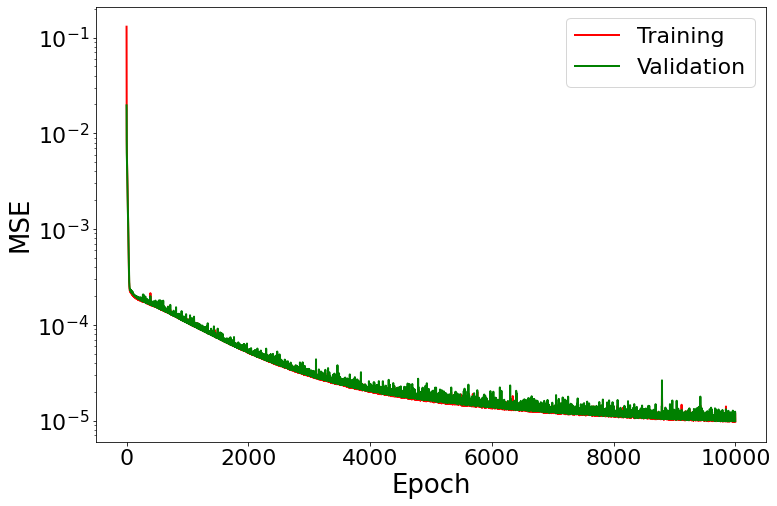

In [13]:
### Training Surrogate

Optimizer = OptimizerName(learning_rate=LearningRate)
NNModel.compile(optimizer=Optimizer, loss='mse')
Training         = NNModel.fit(XTrain, yTrain, batch_size=NBatch, epochs=NEpoch, validation_data=(XTest, yTest), verbose=1);

LossTrainHystory = Training.history['loss']
LossValidHystory = Training.history['val_loss']

# Plotting Training and Validation Loss
fig = plt.figure(figsize=(12, 8))
plt.plot(LossTrainHystory, 'r', label='Training')
plt.plot(LossValidHystory, 'g', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
FigPath = FigDir+'/fig/TrainingNN_'+str(NEpoch)+'Epoches_PCSources.png'
fig.savefig(FigPath, dpi=900)

In [ ]:
### Checking Predictive Accuracy

ySource_ = NNModel.predict(yMatt)

for iy in range(Ny):
    fig  = plt.figure(figsize=(12,12))
    xMin_ = np.amin(ySourcee[:,iy])
    xMax_ = np.amax(ySourcee[:,iy])
    plt.plot(ySourcee[:,iy], ySource_[:,iy], 'ro')
    plt.plot([xMin_,xMax_],[xMin_,xMax_],'k-')
    plt.xlabel('Data')
    plt.ylabel('Prediction')

In [ ]:
### Defining Surrogate ODE

def fOrig_NN(t, y):
    #print(t)
    yy   = (y - xMin)/xRange
    dydt = NNModel.predict(yy[np.newaxis,...])
    dydt = dydt*yRange + yMin
    return dydt[0,:]

In [ ]:
### Evaluating on Test Data

fig = plt.figure(figsize=(16,12))
for iTest in range(3):
    
    output     = solve_ivp( fOrig, tout[[0,-1]], y0Mat[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15 )
    tOrig      = output.t
    yMat       = output.y.T
    
    output     = solve_ivp( fOrig_NN, tout[[0,-1]], y0Mat[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15 )
    tNN        = output.t
    yMat_      = output.y.T
        
    plt.plot(tOrig, yMat[:,0], '-k', label='From ODE',                   lw=2)
    plt.plot(tNN, yMat_[:,0], ':r',  label='From Surrogate Source Term', lw=2)

plt.xlabel('time [s]')
plt.ylabel('x')
plt.legend()